In [1]:
import cooler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import h5py
import pickle
import seaborn as sns
import tqdm

from scipy import stats

from statsmodels.stats.multitest import multipletests

import sys
import itertools
import time
import datetime

sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
from __init__ import *
from __init__jupyterlab import * 
import snmcseq_utils

from enhancer_gene_hic_validation_utils import *

import importlib
importlib.reload(pd)

<module 'pandas' from '/cndd2/fangming/venvs/hic_py3p6/lib/python3.6/site-packages/pandas/__init__.py'>

In [2]:
default_colorbar_kws = DEFAULT_COLORBAR_KWS
today = datetime.date.today()
print(today)

2021-04-21


In [3]:
base_dir = '/cndd2/fangming/sphere_old'

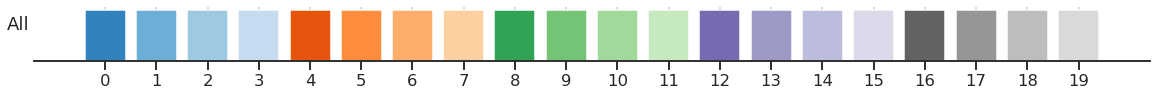

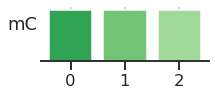

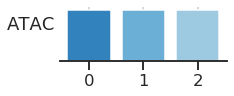

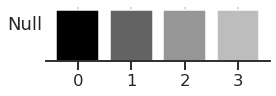

In [4]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [5]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}

KB = 1000


In [6]:
chromosomes = ['chr'+str(i+1) for i in range(22)] + ['chrX']
celltypes = ['L2_3', 'L4', 'L5', 'L6', 
             'Pvalb', 'Sst', 'Vip', 'Ndnf']
resolution = 10000

# prepare data

In [7]:
df_genes = pd.read_csv(GENEBODY, sep='\t')
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes = df_genes.set_index('gid')
df_genes.head()

,gene_id,gene_name,chr,start,end,strand,gene_type
gid,,,,,,,
ENSMUSG00000102693,ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC
ENSMUSG00000064842,ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA
ENSMUSG00000051951,ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding
ENSMUSG00000102851,ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene
ENSMUSG00000103377,ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC


In [8]:
# enhancers lifted
f = './hic_from_ethan/enhancers_lifted.bed'
enh_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'enh_id'])
enh_list['center'] = (enh_list['start'] + enh_list['end'])/2
print(enh_list.shape)
enh_list.head()

# tss lifted
f = './hic_from_ethan/tss_lifted.bed'
tss_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'gid'])
print(tss_list.shape)
tss_list.head()

# enh - tss linked list
# orig significant pairs (enh_index and gid)
f = os.path.join(base_dir, 'enhancers/scripts/results_new/fig2_201027_linked_pairs_mc.tsv')
linked_pairs_mc = pd.read_csv(f, sep="\t")
print(linked_pairs_mc.shape)

f = os.path.join(base_dir, 'enhancers/scripts/results_new/fig2_201027_linked_pairs_atac.tsv')
linked_pairs_atac = pd.read_csv(f, sep="\t")
print(linked_pairs_atac.shape)

f = os.path.join(base_dir, 'enhancers/scripts/results_new/fig2_201027_correlated_pairs_mc.tsv')
correlated_pairs_mc = pd.read_csv(f, sep="\t")
print(correlated_pairs_mc.shape)

f = os.path.join(base_dir, 'enhancers/scripts/results_new/fig2_201027_correlated_pairs_atac.tsv')
correlated_pairs_atac = pd.read_csv(f, sep="\t")
print(correlated_pairs_atac.shape)

# both
linked_pairs_both = pd.merge(linked_pairs_mc, linked_pairs_atac, on=['gene', 'enh', 'dist'])
correlated_pairs_both = pd.merge(correlated_pairs_mc, correlated_pairs_atac, on=['gene', 'enh', 'dist'])
print(linked_pairs_both.shape, 
      correlated_pairs_both.shape, 
     )

linked_pairs_both.head()

(126134, 5)
(33814, 4)
(7455, 3)
(3879, 3)
(85596, 3)
(50012, 3)
(1268, 3) (35309, 3)


,gene,enh,dist
0,ENSMUSG00000000440,191533,39294
1,ENSMUSG00000000440,191534,38506
2,ENSMUSG00000000531,87150,9780
3,ENSMUSG00000000531,87153,11927
4,ENSMUSG00000000552,87351,2705


In [9]:
# gene expression profiles
f = os.path.join(base_dir, 'enhancers/scripts/data_organized/gene_rna_clsts.tsv')
gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0) #header=True, index=True)
print(gene_rna_clsts.shape)
gene_rna_clsts.head()

# cluster annotation
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/ref/annotations_order.tsv'
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(12095, 38)
(38,)


cluster
1-1-1       L4/5 IT (1)
1-2-1       L4/5 IT (2)
1-2-2       L4/5 IT (3)
2-1-1    L6 CT Cpa6 (1)
2-1-2    L6 CT Cpa6 (2)
Name: annotation, dtype: object

In [10]:
# merge cluster name
annot_rename_lookup = {
    'L2/3': "L2_3",
    'L4/5': "L4",
    'L6b': "L6",
    'Sncg': "Ndnf",
    'Lamp5': "Ndnf",
}

def rename_annot(x, annot_rename_lookup):
    """
    """
    if x in annot_rename_lookup.keys():
        return annot_rename_lookup[x]
    else:
        return x

def summarize_by_broad_clsts(df, clst_annot_broad):
    """
    df - feature by clusters
    clst_annot_board - clusters -> coarse grained clusters
    """
    
    df = df.T.copy()
    df['broad_clst'] = clst_annot_broad.reindex(df.index).values
    df = df.groupby('broad_clst', sort=True).mean().T
    
    return df
    
clst_annot_broad = pd.Series([annot.split(' ')[0] for annot in clst_annot.values], 
                             index=clst_annot.index)
clst_annot_broad = clst_annot_broad.apply(lambda x: rename_annot(x, annot_rename_lookup))

print(clst_annot_broad.shape, 
      len(np.unique(clst_annot_broad.values)),
      np.unique(clst_annot_broad.values),
     )

(38,) 8 ['L2_3' 'L4' 'L5' 'L6' 'Ndnf' 'Pvalb' 'Sst' 'Vip']


In [11]:
# enhancers and genes original
# gene list
dirc = os.path.join(base_dir, 'enhancers/scripts/data_organized/')
with snmcseq_utils.cd(dirc):
    f = 'gene_list.txt'
    genes_list_orig = pd.read_csv(f, sep='\t',)
    print(genes_list_orig.shape)

    # enh list
    f = 'enh_list.txt'
    enh_list_orig = pd.read_csv(f, sep='\t',)
    print(enh_list_orig.shape)

    # pair list
    f = 'pair_list.txt'
    to_evals = pd.read_csv(f, sep='\t',)
    print(to_evals.shape)

    f = 'shared_clusters.txt'
    shared_clusters = snmcseq_utils.import_single_textcol(f)
    print(shared_clusters.shape)
    
    f = 'gene_rna_clsts.tsv.gz'
    gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0)
    print(gene_rna_clsts.shape)
    
    f = 'gene_mch_clsts.tsv.gz'
    gene_mch_clsts = pd.read_csv(f, sep='\t', index_col=0)
    print(gene_mch_clsts.shape)
    
    f = 'enh_mcg_clsts.tsv.gz'
    enh_mcg_clsts = pd.read_csv(f, sep='\t', index_col=0)
    print(enh_mcg_clsts.shape)
    
    f = 'enh_atac_clsts.tsv.gz'
    enh_atac_clsts = pd.read_csv(f, sep='\t', index_col=0)
    print(enh_atac_clsts.shape)

(12095, 11)
(152104, 8)


/cndd2/fangming/venvs/hic_py3p6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1710144, 4)
(38,)
(12095, 38)
(12095, 38)
(152104, 38)
(152104, 38)


# Plot function 

In [12]:
from matplotlib.patches import Rectangle
def plot_mat(mat_all, enh_bin, gene_bin, enh_name, gene_name):
    """
    """
    min_bin = min(enh_bin, gene_bin)
    max_bin = max(enh_bin, gene_bin)
    window = max_bin - min_bin
    pad = max(3, int(0.2*window))
    min_bin = min_bin - pad
    max_bin = max_bin + pad 

    title = "{} {} (bin size={:,})".format(celltype, chromosome, resolution)

    mat = mat_all[min_bin:max_bin, min_bin:max_bin] 
    max_diag = np.max(np.diag(mat))
    max_offdiag = np.max(np.triu(mat, k=1)) 

    # plot 
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(
                mat,
                cmap='rocket_r',
                cbar_kws={'fraction': 0.05, 'shrink': 0.4, 'aspect': 5, 
                          'pad': 0.2,
                          'label': "Contact frequency",
                          'ticks': np.arange(0, max_offdiag, 0.05),
                         },
                vmax=max_offdiag,
                rasterized=True,
                ax=ax,
               )
    ax.set_xlim([0, len(mat)])
    ax.set_ylim([len(mat), 0])
    ax.set_aspect('equal')
    ax.set_title(title)
    
    # ticks
    ticks_simple = np.array([0, max_bin-min_bin])
    ticks = np.arange(0, max_bin-min_bin, 10)
    if max_bin-min_bin not in ticks:
        ticks = np.hstack([ticks, [max_bin-min_bin]])
    ax.set_xticks(ticks_simple)
    ax.set_xticklabels(["{:,}".format((min_bin+x)*resolution) for x in ticks_simple],
                       rotation=0,
                      )
    ax.set_yticks(ticks)
    ax.set_yticklabels(["{:,}".format((min_bin+x)*resolution) for x in ticks], 
                       rotation=0,
                      )
    ax.yaxis.tick_right()
    
    # box, lines, text
    if enh_bin < gene_bin:
        idx_pos = (enh_bin - min_bin) # x enh
        idy_pos = (gene_bin - min_bin) # y gene
        # texts by the lines
        ax.text(idx_pos, max_bin-min_bin+0.1, enh_name, va='top', fontsize=8)
        ax.text(0, idy_pos, gene_name, ha='right', va='center', fontsize=15)
    else:
        idx_pos = (gene_bin - min_bin) # x gene 
        idy_pos = (enh_bin - min_bin) # y enh
        # texts by the lines
        ax.text(idx_pos, max_bin-min_bin+0.1, gene_name, va='top', fontsize=15)
        ax.text(0, idy_pos, enh_name, ha='right', va='center', fontsize=8)
        
    # rectangle
    rec = Rectangle((idx_pos, idy_pos), 1, 1, fill=False, edgecolor='black')
    ax.add_patch(rec)
    
    # asterisk
    ax.text(idy_pos+0.5, idx_pos+0.5, '*', ha='center',va='center', fontsize=15, color='white')
    
    # lines
    ax.vlines(idx_pos, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)
    ax.vlines(idx_pos+1, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)
    
    ax.hlines(idy_pos, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
    ax.hlines(idy_pos+1, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
    
    plt.show()

In [13]:
def plot_mat_multi_enh_ax(fig, ax, mat_all, enh_bins, gene_bin, enh_names, gene_name, 
                          celltype, normalize=True,
                          vmin=0, vmax=1,
                          pad_ratio=0.2, plot_ticks=True, **kw_cbars):
    """
    """
    enh_bins_min = np.min(enh_bins)
    
    min_bin = min(enh_bins_min, gene_bin)
    max_bin = max(enh_bins_min, gene_bin)
    pad = max(3, int(pad_ratio*(max_bin - min_bin)))
    min_bin = min_bin - pad
    max_bin = max_bin + pad 

    title = "{}".format(celltype)

    mat = mat_all[min_bin:max_bin, min_bin:max_bin] 
    max_diag = np.max(np.diag(mat))
    max_offdiag = np.max(np.triu(mat, k=1)) 

    # plot 
    if normalize:
        _plotmat = mat/max_offdiag
        vmin, vmax = 0, 1
    else:
        _plotmat = mat
        
    g = sns.heatmap(
                    _plotmat,
                    cmap='rocket_r',
                    vmax=vmax,
                    vmin=vmin,
                    ax=ax,
                    rasterized=True,
                    **kw_cbars,
                    )
    ax.set_xlim([0, len(mat)])
    ax.set_ylim([len(mat), 0])
    ax.set_aspect('equal')
    ax.set_title(title)
    
    # ticks
    if plot_ticks:
        ticks_simple = np.array([0, max_bin-min_bin])
        ticks = np.arange(0, max_bin-min_bin, 10)
        if max_bin-min_bin not in ticks:
            ticks = np.hstack([ticks, [max_bin-min_bin]])
        ax.set_xticks(ticks_simple)
        ax.set_xticklabels(["{:,}".format((min_bin+x)*resolution) for x in ticks_simple],
                           rotation=0,
                          )
        ax.set_yticks([])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # box, lines, text
    flag_genex = flag_geney = False
    for j, (enh_bin, enh_name) in enumerate(zip(enh_bins, enh_names)):
        # box, lines, text
        if enh_bin < gene_bin:
            idx_pos = (enh_bin - min_bin) # x enh
            idy_pos = (gene_bin - min_bin) # y gene
            
            if plot_ticks:
                # texts by the lines
                ax.text(idx_pos, max_bin-min_bin+0.1, enh_name, va='top', fontsize=8, rotation=90)
                if not flag_geney:
                    ax.text(0, idy_pos, gene_name, ha='right', va='center', fontsize=15)

                flag_geney = True
        else:
            idx_pos = (gene_bin - min_bin) # x gene 
            idy_pos = (enh_bin - min_bin) # y enh
            
            if plot_ticks:
                # texts by the lines
                if not flag_genex:
                    ax.text(idx_pos, max_bin-min_bin+0.1, gene_name, va='top', fontsize=15)
                ax.text(0, idy_pos, enh_name, ha='right', va='center', fontsize=8)

                flag_genex = True

        # rectangle
        rec = Rectangle((idx_pos, idy_pos), 1, 1, fill=False, edgecolor='black')
        ax.add_patch(rec)

#         # asterisk
#         ax.text(idy_pos+0.5, idx_pos+0.5, '*', ha='center',va='center', fontsize=15, color='white')

        # lines
        ax.vlines(idx_pos, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)
        ax.vlines(idx_pos+1, ymin=idx_pos+1, ymax=max_bin-min_bin, color='gray', linestyle='--', zorder=1)

        ax.hlines(idy_pos, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
        ax.hlines(idy_pos+1, xmin=0, xmax=idy_pos, color='gray', linestyle='--', zorder=1)
    return ax, g

In [14]:
def plot_mat_multi_enh_wholefig(celltypes, mats_all, enh_bins, gene_bin, enh_names, gene_name, choromosome, resolution, 
                                normalize=True,
                                vmin=0, vmax=1,
                               ):
    """
    """
    if normalize:
        cbar_kws = {'fraction': 0.05, 'shrink': 0.4, 'aspect': 5, # 'pad': 0.2,
                      'label': "Contact frequency\n(Norm. by the max offdiag of each mat)",
                      'ticks': [0, 0.5, 1],
                   }
        vmin, vmax = 0, 1
    else:
        cbar_kws = {'fraction': 0.05, 'shrink': 0.4, 'aspect': 5, # 'pad': 0.2,
                    'label': "Contact frequency",
                    'ticks': np.arange(0, vmax+1e-7, 0.05),
                   }
    pad_ratio = 0.5
    
    fig, axs = plt.subplots(2, 4, figsize=(5*4, 5*2))
    cbar_ax = fig.add_axes([0.95, 0.4, 0.02, 0.2])
    for i, (celltype) in tqdm.tqdm(enumerate(celltypes)):
        ax = axs.flat[i]
        if i == 0:
            plot_ticks = True
            cbar = True 
            cbar_ax = cbar_ax
        else:
            plot_ticks = False
            cbar = False
            cbar_ax = cbar_ax

        mat_all = mats_all["{} {}".format(celltype, chromosome)]
        ax, g = plot_mat_multi_enh_ax(fig, ax, mat_all, enh_bins, gene_bin, enh_names, gene_name, 
                                      celltype,
                                      normalize=normalize,
                                      vmin=vmin, 
                                      vmax=vmax,
                                      pad_ratio=pad_ratio,
                                      plot_ticks=plot_ticks, cbar=cbar, cbar_ax=cbar_ax, cbar_kws=cbar_kws)

    suptitle = "{} {} (bin size={:,})".format(gene_name, chromosome, resolution)
    fig.suptitle(suptitle, y=0.98, fontsize=15) 

    output_tag = "norm" if normalize else "nonorm"
    output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
                  'hic_map_{}_{}_{}_{}.pdf'.format(output_tag, gene_name, resolution, today)
                 )
    print(output_fig)
    snmcseq_utils.savefig(fig, output_fig)

    plt.show()
    
    return

# A specific gene -- Stim2 promising!

In [15]:
resolution = 10000
gene_name = 'Stim2'

try:
    gene_id = df_genes.reset_index().set_index('gene_name').loc[gene_name, 'gid']

    linked_pairs_todo = linked_pairs_both[linked_pairs_both['gene']==gene_id]
    chromosome_spec = tss_list.set_index('gid').loc[gene_id, 'chr']

    print(linked_pairs_todo.shape)
    print(chromosome_spec)
except:
    print("{} skipped".format(gene_name))
#         continue

# get a list of candidate pairs
chromosome = chromosome_spec
# all enhancers and tss on that chromosomes
enhs = enh_list[enh_list['chr']==chromosome]
tsss = tss_list[tss_list['chr']==chromosome]
# get paired bins
paired_bin_table = enh_gene_id_to_binidx(linked_pairs_todo, tsss, enhs, resolution)

(5, 3)
chr4


In [16]:
gene_bin = paired_bin_table['gene_bin'].iloc[0]
chromosome = chromosome_spec
enh_bins = np.sort(paired_bin_table['enh_bin'].values)
enh_names = ["{}:{:,},{:,}".format(_chr, _start, _end)
             for (_chr, _start, _end) in zip(paired_bin_table['enh_chr'], 
                                             paired_bin_table['enh_start'], 
                                             paired_bin_table['enh_end'])
            ]

# get relevant mats
mats_all = {}
for celltype in tqdm.tqdm(celltypes):
    resource_string = (
         '/cndd2/fangming/sphere_old/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
         '::/resolutions/{}'.format(celltype, resolution)
         )
    c = cooler.Cooler(resource_string)
    mat_all = c.matrix(balance=True).fetch(chromosome)
    
    name = "{} {}".format(celltype, chromosome)
    
    if name not in mats_all.keys(): 
        mats_all["{} {}".format(celltype, chromosome)] = mat_all
        
# get contacts on the specific location
contact_by_clsts = []
for i, (idx, row) in enumerate(paired_bin_table.iterrows()):
    gene_bin, enh_bin = row[['gene_bin', 'enh_bin']]
    
    for celltype in celltypes:
        mat_all = mats_all["{} {}".format(celltype, chromosome)]
        val = mat_all[gene_bin, enh_bin]
        contact_by_clsts.append({
                    'local_pair_idx': i,
                    'celltype': celltype,
                    'contact': val, 
                   })
        
contact_by_clsts = pd.DataFrame(contact_by_clsts)
contact_by_clsts = contact_by_clsts.pivot(index='local_pair_idx', columns='celltype')['contact']
print(contact_by_clsts.shape)
contact_by_clsts.head()

100%|██████████| 8/8 [00:27<00:00,  3.38s/it]

(4, 8)


celltype,L2_3,L4,L5,L6,Ndnf,Pvalb,Sst,Vip
local_pair_idx,,,,,,,,
0,0.005449,0.000000,0.015919,0.000000,0.009198,0.0,0.002237,0.009093
1,0.005449,0.000000,0.015919,0.000000,0.009198,0.0,0.002237,0.009093
2,0.014625,0.025603,0.010581,0.033600,0.004349,0.0,0.002112,0.009113
3,0.009636,0.014908,0.006950,0.048805,0.000000,0.0,0.002480,0.007871


8it [00:00,  8.82it/s]


/cndd2/fangming/projects/scf_enhancers/figures/hic_map_norm_Stim2_10000_2021-04-21.pdf


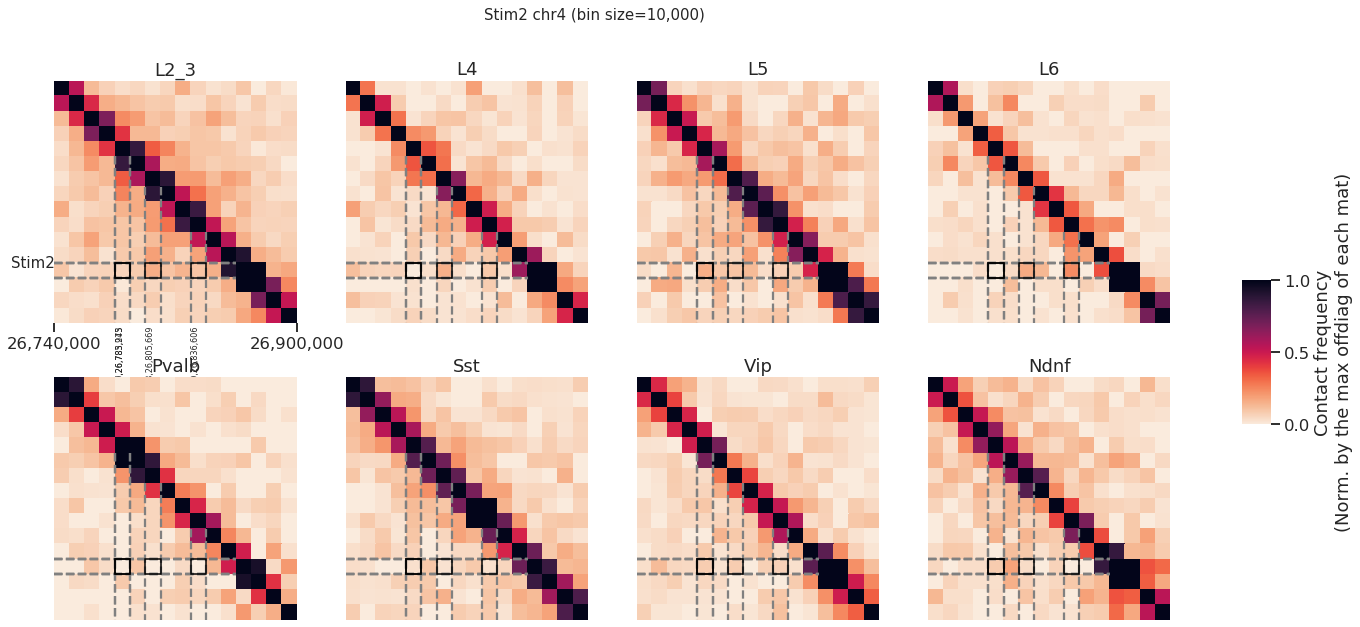

In [17]:
plot_mat_multi_enh_wholefig(celltypes, mats_all, 
                            enh_bins, gene_bin, enh_names, gene_name, 
                            chromosome, resolution) 

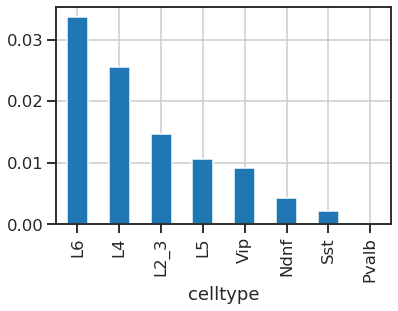

In [18]:
contact_by_clsts.iloc[2].T.sort_values(ascending=False).plot.bar(color='C0')

## find *Stim2* relevant info and plot

In [19]:
def plot_scatter1(gene_name, enh_names_orig, enh_names_lifted, 
                  ploty, plotx1, plotx2, subplot_colors=[], labelpoints=False):
    """
    """
    n = len(plotx1)
    ny = 2
    fig, axss = plt.subplots(n, ny, figsize=(ny*4, n*4), sharey=True)
    if n == 1:
        axss = np.array([axss])
    for j in np.arange(ny):
        axs = axss[:,j]
        _plotx = [plotx1, plotx2,][j]
        _ploty = ploty
        for i in np.arange(n):
            ax = axs[i]
            _x, _y = _plotx.iloc[i].values, _ploty.values
            _celltypes = _ploty.index.values
            if len(subplot_colors) == 0:
                ax.scatter(_x, _y, rasterized=True)
            else:
                ax.scatter(_x, _y, rasterized=True, color=subplot_colors[j])
                
            r, p = stats.spearmanr(_x, _y)
            ax.annotate("r={:.2f}".format(r), xy=(0.95, 0.05), xycoords=ax.transAxes, ha='right', va='bottom', 
                        fontsize=15,
                       )
            
            if labelpoints:
                for __x, __y, __celltype in zip(_x, _y, _celltypes):
                    ax.text(__x, __y, "  {}".format(__celltype), fontsize=12)

            ax.xaxis.set_major_locator(plt.MaxNLocator(4))
            xmin, xmax = np.min(_x), np.max(_x)
            xmin = xmin - 0.1*(xmax-xmin)
            xmax = xmax + 0.1*(xmax-xmin)
            ax.set_xlim(xmin, xmax)
            sns.despine(ax=ax)

            if j == 0:
                ax.set_xlabel('mCG')    
                ax.set_ylabel('RNA')    
                ax.invert_xaxis()
                ax.set_title("{} -> {}".format(enh_names_orig[i], enh_names_lifted[i]))
            elif j == 1:
                ax.set_xlabel('ATAC')    

    fig.subplots_adjust(hspace=0.5)

    output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
                  'scatter_38clusters_{}_{}.pdf'.format(gene_name, today)
                 )
    print(output_fig)
    snmcseq_utils.savefig(fig, output_fig)
    plt.show()

def plot_scatter2(gene_name, enh_names_orig, enh_names_lifted, 
                  plotyb1, plotxb1, plotxb2, plotxb3, subplot_colors=[], 
                  ylim=[], yticks=[],
                 ):
    """
    """
    n = len(plotxb1)
    ny = 3
    fig, axss = plt.subplots(n, ny, figsize=(ny*5, n*5), sharey=True)
    if n == 1:
        axss = np.array([axss])
    for j in np.arange(ny):
        axs = axss[:,j]
        _plotx = [plotxb1, plotxb2, plotxb3][j]
        _ploty = plotyb1
        for i in np.arange(n):
            ax = axs[i]
            _x, _y = _plotx.iloc[i].values, _ploty.iloc[0].values
            _celltypes = _ploty.columns
            if len(subplot_colors) == 0:
                ax.scatter(_x, _y, rasterized=True)
            else:
                ax.scatter(_x, _y, rasterized=True, color=subplot_colors[j])
            
            r, p = stats.spearmanr(_x, _y)
            ax.annotate("r={:.2f}".format(r), xy=(0.95, 0.05), xycoords=ax.transAxes, ha='right', va='bottom', 
                        fontsize=15,
                       )
            for __x, __y, __celltype in zip(_x, _y, _celltypes):
                ax.text(__x, __y, "  {}".format(__celltype), fontsize=12)

            ax.xaxis.set_major_locator(plt.MaxNLocator(4))
            xmin, xmax = np.min(_x), np.max(_x)
            xmin = xmin - 0.1*(xmax-xmin)
            xmax = xmax + 0.1*(xmax-xmin)
            ax.set_xlim(xmin, xmax)
            sns.despine(ax=ax)

            if j == 0:
                ax.set_xlabel('mCG')    
                ax.set_ylabel('RNA')    
                ax.invert_xaxis()
            elif j == 1:
                ax.set_title("{} -> {}".format(enh_names_orig[i], enh_names_lifted[i]))
                ax.set_xlabel('ATAC')    
            elif j == 2:
                ax.set_xlabel('HiC')    

    if len(ylim) > 0:
        ax.set_ylim(ylim)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
        
    fig.subplots_adjust(hspace=0.5)
    output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
                  'scatter_8clusters_{}_{}.pdf'.format(gene_name, today)
                 )
    print(output_fig)
    snmcseq_utils.savefig(fig, output_fig)
    plt.show()
    
subplot_colors_mc_atac = [colors_mc[0], colors_atac[0]]
subplot_colors_mc_atac_hic = [colors_mc[0], colors_atac[0], colors_null[0]]

(4, 12)
ENSMUSG00000039156 [171576 171578 171584 171593] ['chr5_53926006_53926641', 'chr5_53927305_53928317', 'chr5_53942280_53943483', 'chr5_53969740_53970403'] ['chr4_26782570_26783245', 'chr4_26785007_26785973', 'chr4_26804388_26805669', 'chr4_26835900_26836606']
/cndd2/fangming/projects/scf_enhancers/figures/scatter_38clusters_Stim2_2021-04-21.pdf


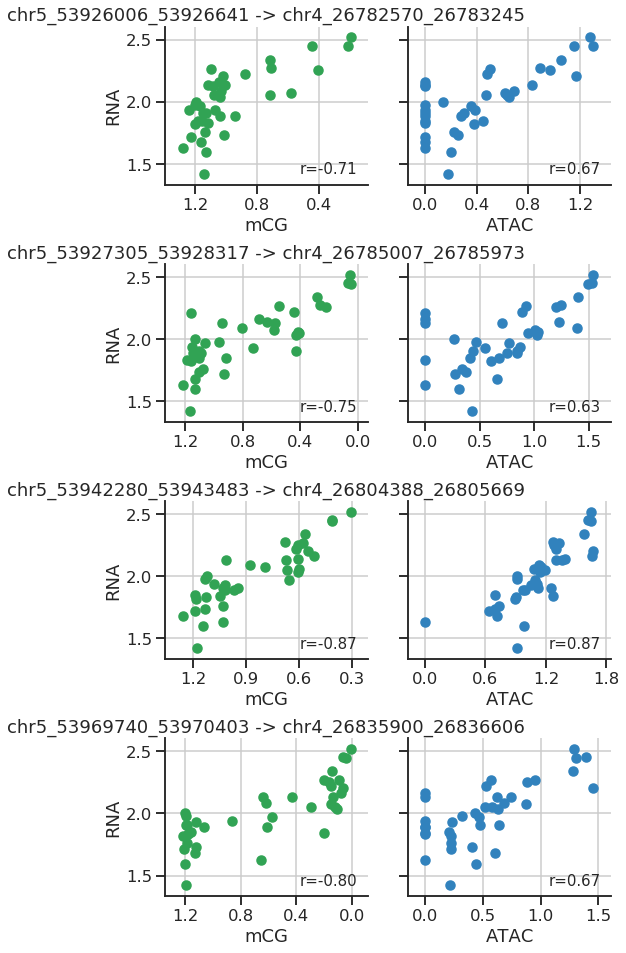

/cndd2/fangming/projects/scf_enhancers/figures/scatter_8clusters_Stim2_2021-04-21.pdf


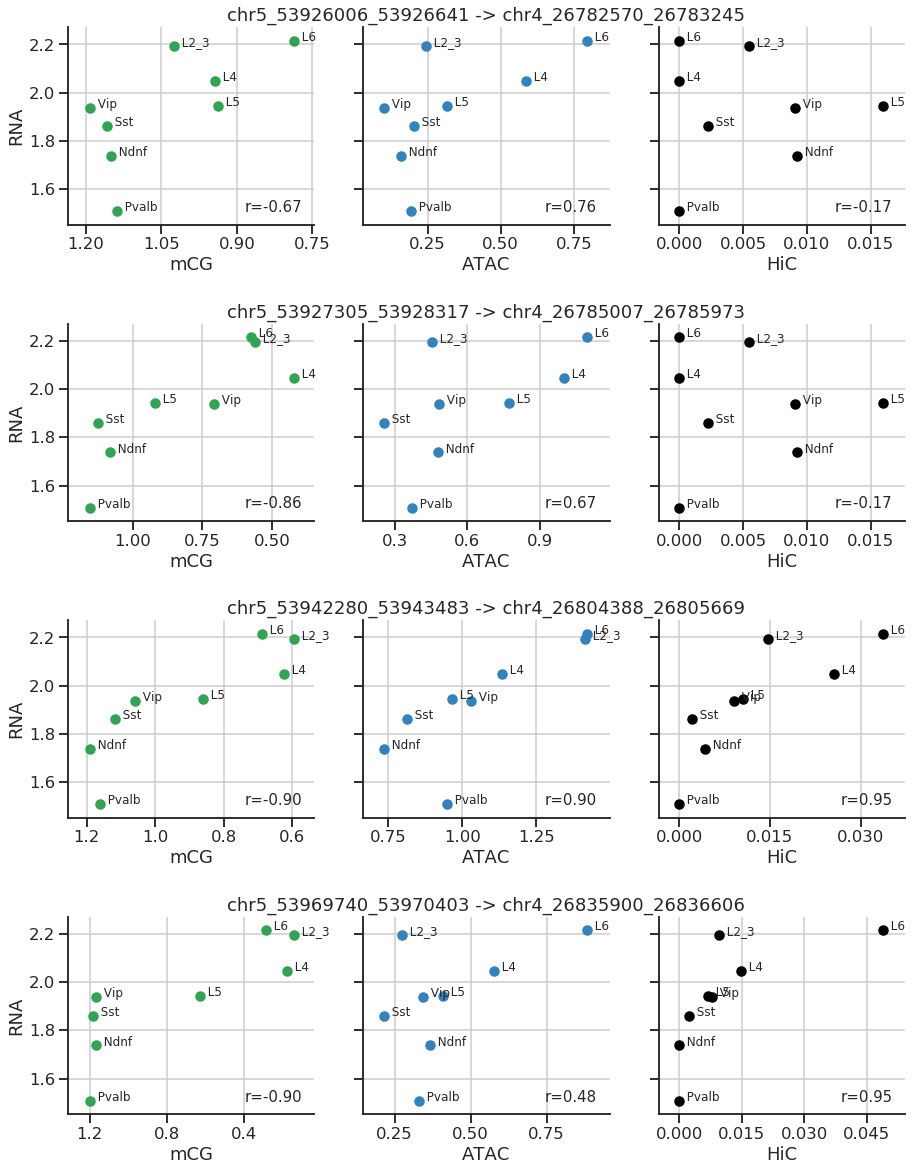

In [20]:
# start from this
print(paired_bin_table.shape)

# gene and enhs
gene_id = paired_bin_table['gene'].iloc[0]
enh_ids = paired_bin_table['enh'].values
enh_names_orig = ["_".join(enh_list_orig.set_index('index').loc[enh_id][['chr', 'start', 'end']].astype(str))
                        for enh_id in enh_ids]
enh_names_lifted = ["_".join(row[['enh_chr', 'enh_start', 'enh_end']].astype(str)) 
                        for idx, row in paired_bin_table.iterrows()]
                      
print(gene_id, enh_ids, enh_names_orig, enh_names_lifted)

# all info 
ploty = gene_rna_clsts.loc[gene_id, shared_clusters]
plotx1 = enh_mcg_clsts.loc[enh_ids, shared_clusters]
plotx2 = enh_atac_clsts.loc[enh_ids, shared_clusters]

# 38 clusters -> 8 clusters
plotyb1 = summarize_by_broad_clsts(ploty.to_frame().T, clst_annot_broad)
plotxb1 = summarize_by_broad_clsts(plotx1, clst_annot_broad)
plotxb2 = summarize_by_broad_clsts(plotx2, clst_annot_broad)
plotxb3 = contact_by_clsts

# plot
plot_scatter1(gene_name, enh_names_orig, enh_names_lifted, 
              ploty, plotx1, plotx2, 
              subplot_colors_mc_atac)
plot_scatter2(gene_name, enh_names_orig, enh_names_lifted, 
              plotyb1, plotxb1, plotxb2, plotxb3,
              subplot_colors_mc_atac_hic)

# summarized - an one enh version only 

In [21]:
# start from this
paired_bin_table_spec = paired_bin_table.iloc[[2]]

# gene and enhs
chromosome = chromosome_spec
gene_bin = paired_bin_table_spec['gene_bin'].iloc[0]
enh_bins = np.sort(paired_bin_table_spec['enh_bin'].values)

gene_id = paired_bin_table_spec['gene'].iloc[0]
enh_ids = paired_bin_table_spec['enh'].values
enh_names_orig = ["_".join(enh_list_orig.set_index('index').loc[enh_id][['chr', 'start', 'end']].astype(str))
                        for enh_id in enh_ids]
enh_names_lifted = ["_".join(row[['enh_chr', 'enh_start', 'enh_end']].astype(str)) 
                        for idx, row in paired_bin_table_spec.iterrows()]

# get relevant mats
mats_all = {}
for celltype in tqdm.tqdm(celltypes):
    resource_string = (
         '/cndd2/fangming/sphere_old/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
         '::/resolutions/{}'.format(celltype, resolution)
         )
    c = cooler.Cooler(resource_string)
    mat_all = c.matrix(balance=True).fetch(chromosome)
    
    name = "{} {}".format(celltype, chromosome)
    
    if name not in mats_all.keys(): 
        mats_all["{} {}".format(celltype, chromosome)] = mat_all
        
# get contacts on the specific location
contact_by_clsts = []
for i, (idx, row) in enumerate(paired_bin_table_spec.iterrows()):
    gene_bin, enh_bin = row[['gene_bin', 'enh_bin']]
    
    for celltype in celltypes:
        mat_all = mats_all["{} {}".format(celltype, chromosome)]
        val = mat_all[gene_bin, enh_bin]
        contact_by_clsts.append({
                    'local_pair_idx': i,
                    'celltype': celltype,
                    'contact': val, 
                   })
contact_by_clsts = pd.DataFrame(contact_by_clsts)
contact_by_clsts = contact_by_clsts.pivot(index='local_pair_idx', columns='celltype')['contact']
print(contact_by_clsts.shape)

# all info 
ploty = gene_rna_clsts.loc[gene_id, shared_clusters]
plotx1 = enh_mcg_clsts.loc[enh_ids, shared_clusters]
plotx2 = enh_atac_clsts.loc[enh_ids, shared_clusters]

# 38 clusters -> 8 clusters
plotyb1 = summarize_by_broad_clsts(ploty.to_frame().T, clst_annot_broad)
plotxb1 = summarize_by_broad_clsts(plotx1, clst_annot_broad)
plotxb2 = summarize_by_broad_clsts(plotx2, clst_annot_broad)
plotxb3 = contact_by_clsts



100%|██████████| 8/8 [00:24<00:00,  3.00s/it]

(1, 8)


/cndd2/fangming/projects/scf_enhancers/figures/scatter_38clusters_Stim2_2021-04-21.pdf


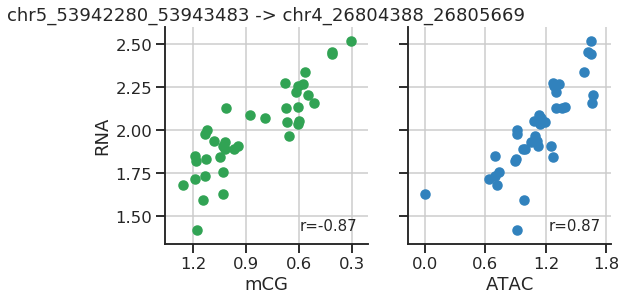

/cndd2/fangming/projects/scf_enhancers/figures/scatter_8clusters_Stim2_2021-04-21.pdf


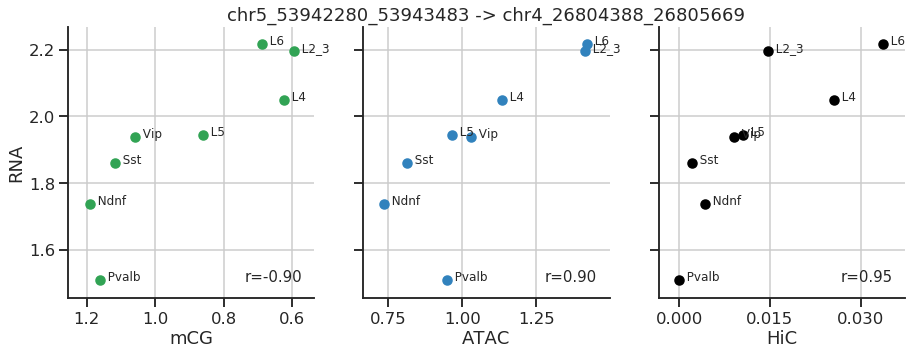

8it [00:00,  9.92it/s]


/cndd2/fangming/projects/scf_enhancers/figures/hic_map_nonorm_Stim2_10000_2021-04-21.pdf


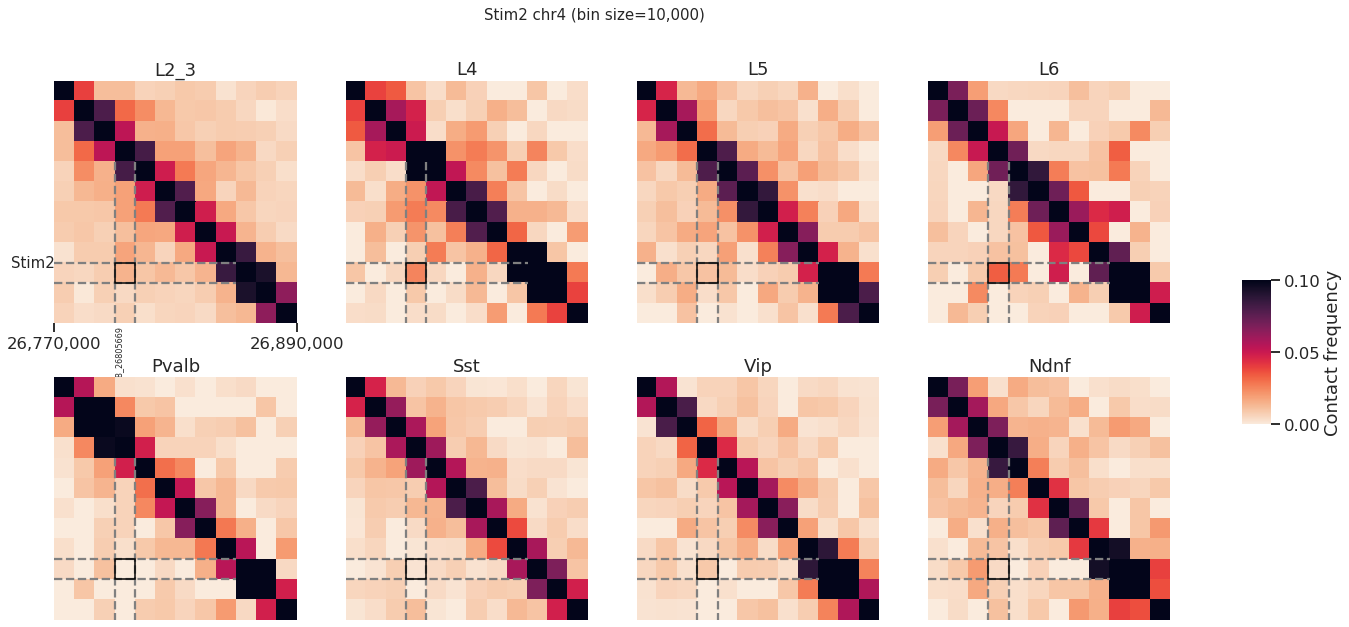

In [22]:
# plot
plot_scatter1(gene_name, enh_names_orig, enh_names_lifted, 
              ploty, plotx1, plotx2,
              subplot_colors_mc_atac)
plot_scatter2(gene_name, enh_names_orig, enh_names_lifted, 
             plotyb1, plotxb1, plotxb2, plotxb3, 
              subplot_colors_mc_atac_hic)

plot_mat_multi_enh_wholefig(celltypes, mats_all, 
                            enh_bins, gene_bin, enh_names_lifted, gene_name, 
                            chromosome, resolution, normalize=False, vmin=0, vmax=0.1, 
                           ) 

# find some false positives 
- Stim2 for now

example
- correlated but not linked
- hic profile 

In [23]:
def get_corr(gene_rna_y, enh_mc_x, enh_atac_x):
    """
    """
    _a = stats.zscore(gene_rna_y.rank(pct=True)) #.apply(stats.zscore)
    _b1 = enh_mc_x.rank(pct=True, axis=1).apply(stats.zscore, axis=1)
    _b2 = enh_atac_x.rank(pct=True, axis=1).apply(stats.zscore, axis=1)
    print(_a.shape, _b1.shape, _b2.shape)

    corrs = pd.DataFrame(np.array([_a.dot(_b1.T), _a.dot(_b2.T)]).T/len(_a), index=enh_mc_x.index, columns=['mc', 'atac'])
    corrs['mean_abs'] = 0.5*(np.abs(corrs['mc'])+np.abs(corrs['atac']))
    corrs = corrs.sort_values('mean_abs', ascending=False)
    print(corrs.shape)
    return corrs


In [24]:
# correlate all enhancers with the gene (for both mC and ATAC)
resolution = 10000
gene_name = 'Stim2'

try:
    gene_id = df_genes.reset_index().set_index('gene_name').loc[gene_name, 'gid']
    gene_rna_y = gene_rna_clsts.loc[gene_id, shared_clusters]
    enh_mc_x = enh_mcg_clsts[shared_clusters]
    enh_atac_x = enh_atac_clsts[shared_clusters]
except:
    print("{} skipped".format(gene_name))
    
corrs = get_corr(gene_rna_y, enh_mc_x, enh_atac_x)
enh_list_orig.set_index('index').reindex(corrs.index).head()
# enh_list.set_index('enh_id').reindex(corrs.index).head()

(38,) (152104, 38) (152104, 38)
(152104, 3)


,chr,start,end,clsts,length,chrom,center
index,,,,,,,
171584,chr5,53942280,53943483,NaN,1203,5,53942881
171583,chr5,53941798,53942254,NaN,456,5,53942026
80934,chr15,52565298,52565867,NaN,569,15,52565582
77108,chr15,10621086,10621754,NaN,668,15,10621420
154446,chr4,28298672,28299549,NaN,877,4,28299110


In [25]:
# 38 clusters -> 8 clusters
# correlate across 8 clusters now
gene_rna_y1 = summarize_by_broad_clsts(gene_rna_y.to_frame().T, clst_annot_broad).iloc[0]
enh_mc_x1 = summarize_by_broad_clsts(enh_mc_x, clst_annot_broad)
enh_atac_x1 = summarize_by_broad_clsts(enh_atac_x, clst_annot_broad)

corrs_8clsts = get_corr(gene_rna_y1, enh_mc_x1, enh_atac_x1)

corrs_8clsts.head()
# enh_list.set_index('enh_id').reindex(corrs.index).head()

(8,) (152104, 8) (152104, 8)
(152104, 3)


,mc,atac,mean_abs
index,,,
39036,0.928571,-1.000000,0.964286
93863,-0.976190,0.952381,0.964286
31314,0.952381,-0.976190,0.964286
83898,0.976190,-0.952381,0.964286
81627,0.976190,-0.952381,0.964286


In [26]:
def plot_scatter3(gene_name, enh, 
#                   corrs, 
                  enh_list_orig, enh_list, 
                  gene_rna_y, enh_mc_x, enh_atac_x,
                  labelpoints=False,
                  ax0_xlim=[], ax0_xticks=[],
                  ax1_xlim=[], ax1_xticks=[], 
                  ax_ylim=[], ax_yticks=[],
                  output="",
                 ):
    """
    """
    
    enh_chr, enh_start, enh_end = enh_list_orig.set_index('index').loc[enh, ['chr', 'start', 'end']]
    enh_name = "{}:{:,}-{:,}".format(enh_chr, enh_start, enh_end)
    try:
        enh_chr_hg19, enh_start_hg19, enh_end_hg19 = enh_list.set_index('enh_id').loc[enh, ['chr', 'start', 'end']]
        enh_name_hg19 = "{}:{:,}-{:,}".format(enh_chr_hg19, enh_start_hg19, enh_end_hg19)
    except:
        enh_name_hg19 = '-'
    
    r1, p1 = stats.spearmanr(gene_rna_y, enh_mc_x.loc[enh])
    r2, p2 = stats.spearmanr(gene_rna_y, enh_atac_x.loc[enh])
    
    _celltypes = gene_rna_y.index.values
    
    _y = gene_rna_y
    _x1 = enh_mc_x.loc[enh]
    _x2 = enh_atac_x.loc[enh]
    color1, color2 = [colors_mc[0], colors_atac[0]]
    
    fig, axs = plt.subplots(1, 2, figsize=(5*2,5),sharey=False)
    ax = axs[0]
    ax.scatter(_x1, _y, color=color1)
    ax.invert_xaxis()
    sns.despine(ax=ax)
    ax.set_title("r = {:.2f}, p = {:.1}".format(r1, p1))
    ax.set_ylabel('{} RNA'.format(gene_name))
    ax.set_xlabel('Enhancer mCG (axis reversed)')
    if labelpoints:
        for __x, __y, __celltype in zip(_x1, _y, _celltypes):
            ax.text(__x, __y, "  {}".format(__celltype), fontsize=12)
    # this order is extremely important - first set ticks; then set lim!
    ax.yaxis.set_major_locator(mtick.MaxNLocator(4))
    if len(ax0_xticks) > 0:
        ax.set_xticks(ax0_xticks)
    if len(ax0_xlim) > 0:
        ax.set_xlim(ax0_xlim)
    if len(ax_yticks) > 0:
        ax.set_yticks(ax_yticks)
    if len(ax_ylim) > 0:
        ax.set_ylim(ax_ylim)
    
    ax = axs[1]
    ax.scatter(_x2, _y, color=color2)
    sns.despine(ax=ax)
    ax.set_title("r = {:.2f}, p = {:.2}".format(r2, p2))
    ax.set_xlabel('Enhancer ATAC')
    if labelpoints:
        for __x, __y, __celltype in zip(_x2, _y, _celltypes):
            ax.text(__x, __y, "  {}".format(__celltype), fontsize=12)
    # this order is extremely important - first set ticks; then set lim!
    ax.yaxis.set_major_locator(mtick.MaxNLocator(4))
    if len(ax1_xticks) > 0:
        ax.set_xticks(ax1_xticks)
    if len(ax1_xlim) > 0:
        ax.set_xlim(ax1_xlim)
    if len(ax_yticks) > 0:
        ax.set_yticks(ax_yticks)
    if len(ax_ylim) > 0:
        ax.set_ylim(ax_ylim)
    
    ax.annotate("{} -> {}".format(enh_name, enh_name_hg19), 
                xy=(0.5, 0), xycoords='figure fraction',
                ha='center', 
                va='bottom',
                annotation_clip=False,
                #  fontsize=15,
               )
    if output:
        print(output)
        snmcseq_utils.savefig(fig, output)
    plt.show()
    
    return (
        axs[0].get_xlim(), axs[0].get_xticks(),
        axs[1].get_xlim(), axs[1].get_xticks(),
        axs[0].get_ylim(), axs[0].get_yticks(),
        )

In [28]:
# # scatter plot
# # choose with enhancers to correlate [0, 2]
# for enh in corrs.iloc[[0,2,3,6]].index:
#     print(enh)
#     # plot 38 clusters
#     output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
#                   'scatter_38clusters_stim2_enh{}_{}.pdf'
#                   .format(enh, today)
#                  )
#     # this is to make sure the two plots (38 clusters and 8 clusters) have the same axis
#     (ax0_xlim, ax0_xticks, ax1_xlim, ax1_xticks, ax_ylim, ax_yticks) = plot_scatter3(
#         gene_name, enh, corrs, 
#         enh_list_orig, enh_list, 
#         gene_rna_y, enh_mc_x, enh_atac_x,
#         output=output_fig,
#         )
    
#     # plot 8 clusters
#     output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
#                   'scatter_8clusters_stim2_enh{}_{}.pdf'
#                   .format(enh, today)
#                  )
#     plot_scatter3(
#         gene_name, enh, corrs_8clsts, 
#         enh_list_orig, enh_list, 
#         gene_rna_y1, enh_mc_x1, enh_atac_x1,
#         labelpoints=True,
#         ax0_xlim=ax0_xlim, 
#         ax0_xticks=ax0_xticks, 
#         ax1_xlim=ax1_xlim, 
#         ax1_xticks=ax1_xticks, 
#         ax_ylim=ax_ylim, 
#         ax_yticks=ax_yticks,
#         output=output_fig
#         )

In [29]:
# start from this
enh = corrs.iloc[[0]].index[0] 
paired_bin_table_spec = paired_bin_table.set_index('enh').loc[[enh]].reset_index() 

# gene and enhs
chromosome = chromosome_spec
gene_bin = paired_bin_table_spec['gene_bin'].iloc[0]
enh_bins = np.sort(paired_bin_table_spec['enh_bin'].values)

gene_id = paired_bin_table_spec['gene'].iloc[0]
enh_ids = paired_bin_table_spec['enh'].values
enh_names_orig = ["_".join(enh_list_orig.set_index('index').loc[enh_id][['chr', 'start', 'end']].astype(str))
                        for enh_id in enh_ids]
enh_names_lifted = ["_".join(row[['enh_chr', 'enh_start', 'enh_end']].astype(str)) 
                        for idx, row in paired_bin_table_spec.iterrows()]

# get relevant mats
mats_all = {}
for celltype in tqdm.tqdm(celltypes):
    resource_string = (
         '/cndd2/fangming/sphere_old/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
         '::/resolutions/{}'.format(celltype, resolution)
         )
    c = cooler.Cooler(resource_string)
    mat_all = c.matrix(balance=True).fetch(chromosome)
    
    name = "{} {}".format(celltype, chromosome)
    
    if name not in mats_all.keys(): 
        mats_all["{} {}".format(celltype, chromosome)] = mat_all
        
# get contacts on the specific location
contact_by_clsts = []
for i, (idx, row) in enumerate(paired_bin_table_spec.iterrows()):
    gene_bin, enh_bin = row[['gene_bin', 'enh_bin']]
    
    for celltype in celltypes:
        mat_all = mats_all["{} {}".format(celltype, chromosome)]
        val = mat_all[gene_bin, enh_bin]
        contact_by_clsts.append({
                    'local_pair_idx': i,
                    'celltype': celltype,
                    'contact': val, 
                   })
contact_by_clsts = pd.DataFrame(contact_by_clsts)
contact_by_clsts = contact_by_clsts.pivot(index='local_pair_idx', columns='celltype')['contact']
print(contact_by_clsts.shape)

# all info 
ploty = gene_rna_clsts.loc[gene_id, shared_clusters]
plotx1 = enh_mcg_clsts.loc[enh_ids, shared_clusters]
plotx2 = enh_atac_clsts.loc[enh_ids, shared_clusters]

# 38 clusters -> 8 clusters
plotyb1 = summarize_by_broad_clsts(ploty.to_frame().T, clst_annot_broad)
plotxb1 = summarize_by_broad_clsts(plotx1, clst_annot_broad)
plotxb2 = summarize_by_broad_clsts(plotx2, clst_annot_broad)
plotxb3 = contact_by_clsts


100%|██████████| 8/8 [00:24<00:00,  3.06s/it]

(1, 8)


In [30]:
def plot_scatter4(gene_name, enh_names_orig, enh_names_lifted, 
                  plotyb1, plotxb1, plotxb2, plotxb3, 
                  subplot_colors=[], 
                  ax0_xlim=[], ax1_xlim=[],
                  ylim=[], yticks=[],
                  output="",
                 ):
    """
    """
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    _plotx = plotxb3
    _ploty = plotyb1

    _x, _y = _plotx.iloc[0].values, _ploty.iloc[0].values
    _celltypes = _ploty.columns
    if len(subplot_colors) == 0:
        ax.scatter(_x, _y,)
    else:
        ax.scatter(_x, _y, color=subplot_colors[2])

    r, p = stats.spearmanr(_x, _y)
    ax.annotate("r = {:.2f}, p = {:.1}".format(r, p), xy=(0.95, 0.05), xycoords=ax.transAxes, ha='right', va='bottom', 
                fontsize=15,
               )
    for __x, __y, __celltype in zip(_x, _y, _celltypes):
        ax.text(__x, __y, "  {}".format(__celltype), fontsize=12)

    sns.despine(ax=ax)

    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    xmin, xmax = np.min(_x), np.max(_x)
    xmin = xmin - 0.1*(xmax-xmin)
    xmax = xmax + 0.1*(xmax-xmin)
    ax.set_xlim(xmin, xmax)

    # this order is extremely important - first set ticks; then set lim!
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    if len(ylim) > 0:
        ax.set_ylim(ylim)

    ax.set_title("{} -> {}".format(enh_names_orig[i], enh_names_lifted[i]))
    ax.set_xlabel('HiC')    

    if output:
        print(output)
        snmcseq_utils.savefig(fig, output)
    plt.show()

/cndd2/fangming/projects/scf_enhancers/figures/scatter_38clusters_stim2_enh171584_2021-04-21.pdf


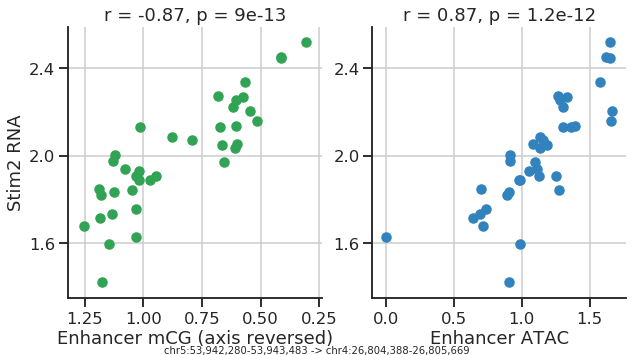

/cndd2/fangming/projects/scf_enhancers/figures/scatter_8clusters_stim2_enh171584_2021-04-21.pdf


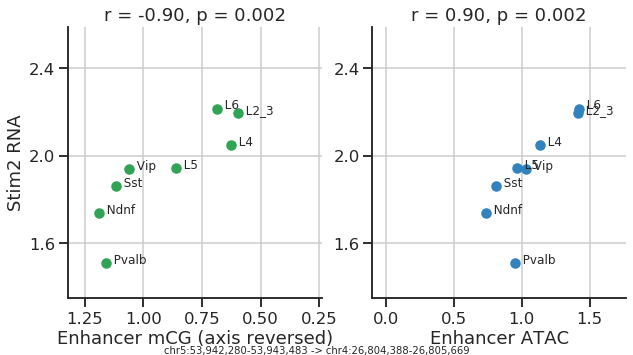

/cndd2/fangming/projects/scf_enhancers/figures/scatter_8clusters_3mod_Stim2_2021-04-21.pdf


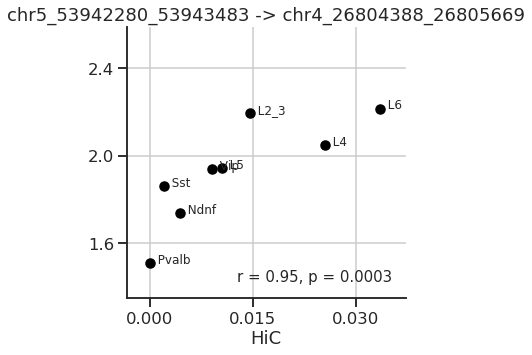

In [31]:

# 3 plots of the same enhancer-gene pair
# 38 cluster version; 8 cluster version; 
output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
              'scatter_38clusters_stim2_enh{}_{}.pdf'
              .format(enh, today)
             )
(ax0_xlim, ax0_xticks, ax1_xlim, ax1_xticks, ax_ylim, ax_yticks) = plot_scatter3(
    gene_name, enh, 
    enh_list_orig, enh_list, 
    gene_rna_y, enh_mc_x, enh_atac_x,
    output=output_fig,
    )

output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
              'scatter_8clusters_stim2_enh{}_{}.pdf'
              .format(enh, today)
             )
plot_scatter3(
    gene_name, enh, 
    enh_list_orig, enh_list, 
    gene_rna_y1, enh_mc_x1, enh_atac_x1,
    labelpoints=True,
    ax0_xlim=ax0_xlim, 
    ax0_xticks=ax0_xticks, 
    ax1_xlim=ax1_xlim, 
    ax1_xticks=ax1_xticks, 
    ax_ylim=ax_ylim, 
    ax_yticks=ax_yticks,
    output=output_fig
    )

output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
              'scatter_8clusters_3mod_{}_{}.pdf'.format(gene_name, today)
             )
plot_scatter4(gene_name, enh_names_orig, enh_names_lifted, 
              plotyb1, plotxb1, plotxb2, plotxb3, 
              subplot_colors=subplot_colors_mc_atac_hic, 
              ax0_xlim=ax0_xlim,
              ax1_xlim=ax1_xlim,
              ylim=ax_ylim, yticks=ax_yticks,
              output=output_fig,
             )

### annoj_tracks

In [32]:
f = '/cndd2/fangming/projects/scf_enhancers/scripts/annoj_biccn_mop_track_list.txt'

all_tracks = []
with open(f, 'r') as fh:
    for line in fh:
        idx, text = line.strip('\n').split(': {')
        item_dict = {}
        item_dict['index'] = int(idx)
        
        items = text.split(',')
        for item in items:
            try:
                key, val = item.split(': ')
                item_dict[key] = val
            except:
                pass
        all_tracks.append(item_dict)
        
all_tracks = pd.DataFrame(all_tracks)
print(all_tracks.shape)
all_tracks.head()

(441, 6)


,data,name,path,type,id,index
0,"""./browser/fetchers/models/genes_mm10.php""","""Gene Models (mm10)""","""Annotation models""","""ModelsTrack""","""gene_model_mm10""",0
1,"""./browser/fetchers/models/genes_mm10_gencode....","""Gene Models (mm10 Gencode vM2)""","""Annotation models""","""ModelsTrack""","""gene_model_mm10_gencode_vM2""",1
2,"""./browser/fetchers/mc/mc_round2_C4_1.php""","""mCG L2/3 IT (1-2) C4_1""","""Epigenome/DNA Methylation""","""MethTrack""","""mcg_ens2_C4_1_CGN""",2
3,"""./browser/fetchers/mc/mc_round2_C4_1_CAC.php""","""mCAC L2/3 IT (1-2) C4_1""","""Epigenome/DNA Methylation""","""MethTrack""","""mcac_ens2_C4_1_CAC""",3
4,"""./browser/fetchers/atac/atac_round2_C4_1.php""","""ATAC L2/3 IT (1-2) C4_1""","""Epigenome/ATAC-Seq""","""PairedEndTrack""","""atac_ens2_C4_1""",4


In [33]:
selected_list = [0, 
                 433, # enh CT
                 427,428,429,430,431,432,434,435,436,437,438,439,440, # other enhs
                 37,39,41, # L6 CT Cpa6
                 2,4,6, # L2/3 IT
                 12,14,16, # L4/5 IT
                 22,24,26, # L5 IT
                 107,109,111, # Sst Calb2
                 127,129,131, # Lamp5 Slc35d3
                 117,119,121, # Vip Chat
                 87,89,91, # Pvalb Reln
                ]

In [34]:
selected_tracks = all_tracks.loc[selected_list]
selected_tracks

,data,name,path,type,id,index
0,"""./browser/fetchers/models/genes_mm10.php""","""Gene Models (mm10)""","""Annotation models""","""ModelsTrack""","""gene_model_mm10""",0
433,"""./browser/fetchers/dmr/ENHANCER_ens2_L6_CT.php""","""Enhancer ens2 C2_3 L6_CT""","""Enhancers""","""PairedEndTrack""","""Enhancer_ens2_L6_CT""",433
427,"""./browser/fetchers/dmr/ENHANCER_mESC.php""","""Enhancer mESC""","""Enhancers""","""PairedEndTrack""","""Enhancer_mESC""",427
428,"""./browser/fetchers/dmr/ENHANCER_ens2_L23_IT.php""","""Enhancer ens2 C4_2 L23_IT""","""Enhancers""","""PairedEndTrack""","""Enhancer_ens2_L23_IT""",428
429,"""./browser/fetchers/dmr/ENHANCER_ens2_L5_PT.php""","""Enhancer ens2 C9_1 L5_PT""","""Enhancers""","""PairedEndTrack""","""Enhancer_ens2_L5_PT""",429
430,"""./browser/fetchers/dmr/ENHANCER_ens2_L45_IT_1...","""Enhancer ens2 C1_1 L45_IT_1""","""Enhancers""","""PairedEndTrack""","""Enhancer_ens2_L45_IT_1""",430
431,"""./browser/fetchers/dmr/ENHANCER_ens2_L45_IT_2...","""Enhancer ens2 C1_2 L45_IT_2""","""Enhancers""","""PairedEndTrack""","""Enhancer_ens2_L45_IT_2""",431
432,"""./browser/fetchers/dmr/ENHANCER_ens2_L5_IT_S1...","""Enhancer ens2 C3_2 L5_IT_S100b""","""Enhancers""","""PairedEndTrack""","""Enhancer_ens2_L5_IT_S100b""",432
434,"""./browser/fetchers/dmr/ENHANCER_ens2_L6_IT.php""","""Enhancer ens2 C3_1 L6_IT""","""Enhancers""","""PairedEndTrack""","""Enhancer_ens2_L6_IT""",434
435,"""./browser/fetchers/dmr/ENHANCER_ens2_L6_NP.php""","""Enhancer ens2 C7_1 L6_NP""","""Enhancers""","""PairedEndTrack""","""Enhancer_ens2_L6_NP""",435


In [35]:
def config_url(loc_tag='5:53998222:300:1', track_tag='0:2:4:6'):
    """
    """
    url_template = ("https://brainome.ucsd.edu/annoj/BICCN_MOp/index.html"
                    "?location={}"
                    "&scaleFactor=1.00:1.00:1.00&ensemble=2&groupby=celltype&modalities=mcg:atac:scrna:enhancer&celltype=custom"
                    "&tracks={}"
                   )
    url = url_template.format(loc_tag, track_tag)
    return url

In [36]:
track_tag = ":".join(selected_tracks['index'].astype(str).tolist())
# first enh
loc_tag="5:53942280:300:1"
url = config_url(loc_tag=loc_tag, track_tag=track_tag)
print(url)
# third enh
loc_tag="15:52565298:300:1"
url = config_url(loc_tag=loc_tag, track_tag=track_tag)
print(url)

https://brainome.ucsd.edu/annoj/BICCN_MOp/index.html?location=5:53942280:300:1&scaleFactor=1.00:1.00:1.00&ensemble=2&groupby=celltype&modalities=mcg:atac:scrna:enhancer&celltype=custom&tracks=0:433:427:428:429:430:431:432:434:435:436:437:438:439:440:37:39:41:2:4:6:12:14:16:22:24:26:107:109:111:127:129:131:117:119:121:87:89:91
https://brainome.ucsd.edu/annoj/BICCN_MOp/index.html?location=15:52565298:300:1&scaleFactor=1.00:1.00:1.00&ensemble=2&groupby=celltype&modalities=mcg:atac:scrna:enhancer&celltype=custom&tracks=0:433:427:428:429:430:431:432:434:435:436:437:438:439:440:37:39:41:2:4:6:12:14:16:22:24:26:107:109:111:127:129:131:117:119:121:87:89:91


### Figure out which enhancers to plot
- a true positive (the first one in corrs?)
- a false positive (the third one?) 



In [37]:
ntop = 20
corrs.head(ntop)

,mc,atac,mean_abs
index,,,
171584,-0.872634,0.870883,0.871758
171583,-0.790130,0.916015,0.853072
80934,-0.860597,0.841961,0.851279
77108,-0.872853,0.812149,0.842501
154446,-0.857971,0.810308,0.834140
137383,-0.818296,0.846419,0.832358
136322,-0.815670,0.843223,0.829447
5014,-0.803042,0.853203,0.828123
188984,-0.885764,0.758126,0.821945


In [38]:
enh_list_orig.set_index('index').reindex(corrs.index).head(ntop)

,chr,start,end,clsts,length,chrom,center
index,,,,,,,
171584,chr5,53942280,53943483,NaN,1203,5,53942881
171583,chr5,53941798,53942254,NaN,456,5,53942026
80934,chr15,52565298,52565867,NaN,569,15,52565582
77108,chr15,10621086,10621754,NaN,668,15,10621420
154446,chr4,28298672,28299549,NaN,877,4,28299110
137383,chr2,165842531,165842714,NaN,183,2,165842622
136322,chr2,157409782,157410490,NaN,708,2,157410136
5014,chr1,60845491,60846730,NaN,1239,1,60846110
188984,chr6,94584677,94585362,NaN,685,6,94585019


In [39]:
for i, (idx, row) in enumerate(enh_list_orig.set_index('index').reindex(corrs.index).head(ntop).iterrows()):
    
    chrom, start, end = row[['chr', 'start', 'end']] 
    loc_tag = "{}:{}:300:1".format(chrom[len('chr'):], start)
    url = config_url(loc_tag=loc_tag, track_tag=track_tag)
    print(i, chrom, start, end)
    print(url)

0 chr5 53942280 53943483
https://brainome.ucsd.edu/annoj/BICCN_MOp/index.html?location=5:53942280:300:1&scaleFactor=1.00:1.00:1.00&ensemble=2&groupby=celltype&modalities=mcg:atac:scrna:enhancer&celltype=custom&tracks=0:433:427:428:429:430:431:432:434:435:436:437:438:439:440:37:39:41:2:4:6:12:14:16:22:24:26:107:109:111:127:129:131:117:119:121:87:89:91
1 chr5 53941798 53942254
https://brainome.ucsd.edu/annoj/BICCN_MOp/index.html?location=5:53941798:300:1&scaleFactor=1.00:1.00:1.00&ensemble=2&groupby=celltype&modalities=mcg:atac:scrna:enhancer&celltype=custom&tracks=0:433:427:428:429:430:431:432:434:435:436:437:438:439:440:37:39:41:2:4:6:12:14:16:22:24:26:107:109:111:127:129:131:117:119:121:87:89:91
2 chr15 52565298 52565867
https://brainome.ucsd.edu/annoj/BICCN_MOp/index.html?location=15:52565298:300:1&scaleFactor=1.00:1.00:1.00&ensemble=2&groupby=celltype&modalities=mcg:atac:scrna:enhancer&celltype=custom&tracks=0:433:427:428:429:430:431:432:434:435:436:437:438:439:440:37:39:41:2:4:6:12

# Candidate sites - for figures

- 0 chr5 - the original one next to Stim2
- 2 chr15 - false positive one near no gene 
- 6 chr2 157409782 157410490 - Src (true link is less correlated)
- 11 chr18 15078249 15078585 - Kctd1 (true link is more correlated)

In [266]:
def plot_scatter5(
                  fig, axs,
                  gene_name, enh, 
                  enh_list_orig, enh_list, 
                  gene_rna_y, enh_mc_x, enh_atac_x,
                  labelpoints=False,
                  annotate=True,
                  ax0_xlim=[], ax0_xticks=[],
                  ax1_xlim=[], ax1_xticks=[], 
                  ax_ylim=[], ax_yticks=[],
                  **kwargs,
                 ):
    """
    """
    
    enh_chr, enh_start, enh_end = enh_list_orig.set_index('index').loc[enh, ['chr', 'start', 'end']]
    enh_name = "{}:{:,}-{:,}".format(enh_chr, enh_start, enh_end)
    try:
        enh_chr_hg19, enh_start_hg19, enh_end_hg19 = enh_list.set_index('enh_id').loc[enh, ['chr', 'start', 'end']]
        enh_name_hg19 = "{}:{:,}-{:,}".format(enh_chr_hg19, enh_start_hg19, enh_end_hg19)
    except:
        enh_name_hg19 = '-'
    
    r1, p1 = stats.spearmanr(gene_rna_y, enh_mc_x.loc[enh])
    r2, p2 = stats.spearmanr(gene_rna_y, enh_atac_x.loc[enh])
    
    _celltypes = gene_rna_y.index.values
    
    _y = gene_rna_y
    _x1 = enh_mc_x.loc[enh]
    _x2 = enh_atac_x.loc[enh]
    color1, color2 = [colors_mc[0], colors_atac[0]]
    
    ax = axs[0]
    ax.scatter(_x1, _y, color=color1, **kwargs)
    ax.invert_xaxis()
    sns.despine(ax=ax)
    ax.set_title(ax.get_title()+"\nr = {:.2f}, p = {:.1}, n={}".format(r1, p1, len(gene_rna_y)))
    if labelpoints:
        for __x, __y, __celltype in zip(_x1, _y, _celltypes):
            ax.text(__x, __y, "  {}".format(__celltype), fontsize=12)
    # this order is extremely important - first set ticks; then set lim!
    ax.yaxis.set_major_locator(mtick.MaxNLocator(4))
    if len(ax0_xticks) > 0:
        ax.set_xticks(ax0_xticks)
    if len(ax0_xlim) > 0:
        ax.set_xlim(ax0_xlim)
    if len(ax_yticks) > 0:
        ax.set_yticks(ax_yticks)
    if len(ax_ylim) > 0:
        ax.set_ylim(ax_ylim)
    
    if annotate:
        ax.set_ylabel('{} RNA'.format(gene_name))
        ax.set_xlabel('Enhancer mCG (axis reversed)')
    
    ax = axs[1]
    ax.scatter(_x2, _y, color=color2, **kwargs)
    sns.despine(ax=ax)
    ax.set_title(ax.get_title()+"\nr = {:.2f}, p = {:.2}, n={}".format(r2, p2, len(gene_rna_y)))
    if labelpoints:
        for __x, __y, __celltype in zip(_x2, _y, _celltypes):
            ax.text(__x, __y, "  {}".format(__celltype), fontsize=12)
    # this order is extremely important - first set ticks; then set lim!
    ax.yaxis.set_major_locator(mtick.MaxNLocator(4))
    if len(ax1_xticks) > 0:
        ax.set_xticks(ax1_xticks)
    if len(ax1_xlim) > 0:
        ax.set_xlim(ax1_xlim)
    if len(ax_yticks) > 0:
        ax.set_yticks(ax_yticks)
    if len(ax_ylim) > 0:
        ax.set_ylim(ax_ylim)
    
    if annotate:
        ax.set_xlabel('Enhancer ATAC')
        ax.annotate("{} -> {}".format(enh_name, enh_name_hg19), 
                    xy=(0.5, 0), xycoords='figure fraction',
                    ha='center', 
                    va='bottom',
                    annotation_clip=False,
                    #  fontsize=15,
                   )
    return (
        axs[0].get_xlim(), axs[0].get_xticks(),
        axs[1].get_xlim(), axs[1].get_xticks(),
        axs[0].get_ylim(), axs[0].get_yticks(),
        )

In [40]:
candidates = [
    (corrs.iloc[[0]].index[0], 'Stim2'), 
    (corrs.iloc[[2]].index[0], 'Stim2'), 
    (corrs.iloc[[6]].index[0], 'Src'), 
    (corrs.iloc[[11]].index[0], 'Kctd1'), 
]

(38,) (1, 38) (1, 38)
(1, 3)
(8,) (1, 8) (1, 8)
(1, 3)
-0.872633767371 9.36606715763e-13
0.870883028778 1.17972805171e-12
-0.872633767371 9.36606715763e-13
0.870883028778 1.17972805171e-12
23 chr5 53942280 53943483
https://brainome.ucsd.edu/annoj/BICCN_MOp/index.html?location=5:53942280:300:1&scaleFactor=1.00:1.00:1.00&ensemble=2&groupby=celltype&modalities=mcg:atac:scrna:enhancer&celltype=custom&tracks=0:433:427:428:429:430:431:432:434:435:436:437:438:439:440:37:39:41:2:4:6:12:14:16:22:24:26:107:109:111:127:129:131:117:119:121:87:89:91
/cndd2/fangming/projects/scf_enhancers/figures/scatter_38and8_clusters_stim2_enh171584_2021-04-21.pdf
/cndd2/fangming/projects/scf_enhancers/figures/scatter_38and8_clusters_stim2_fp_enh171584_2021-04-21.pdf
(38,) (1, 38) (1, 38)
(1, 3)
(8,) (1, 8) (1, 8)
(1, 3)
-0.860597439545 4.29211332047e-12
0.8419612766 3.49698716521e-11
-0.860597439545 4.29211332047e-12
0.8419612766 3.49698716521e-11
23 chr15 52565298 52565867
https://brainome.ucsd.edu/annoj/BICCN_

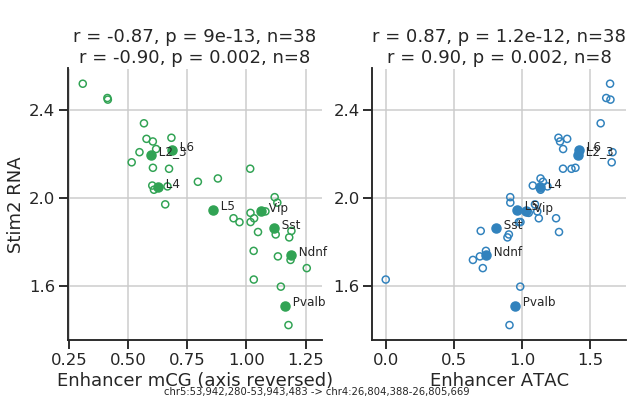

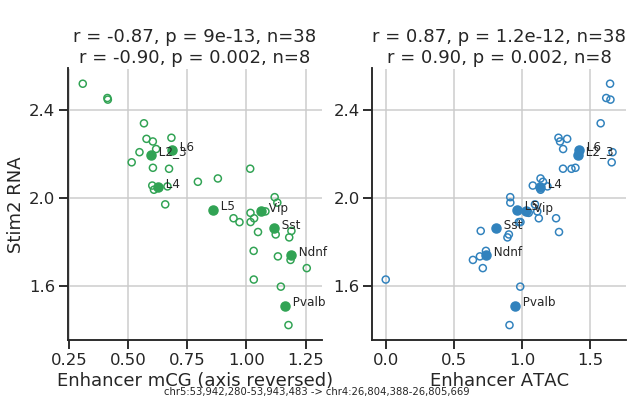

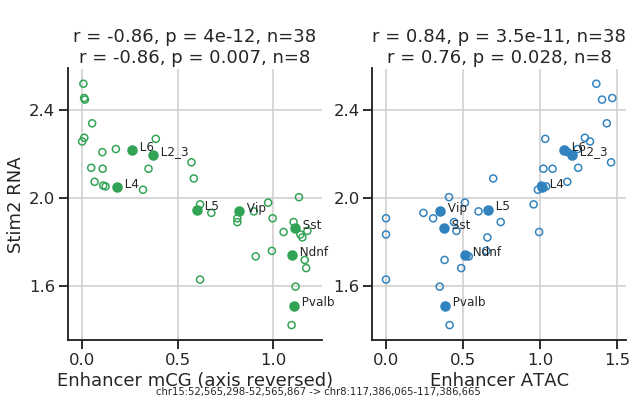

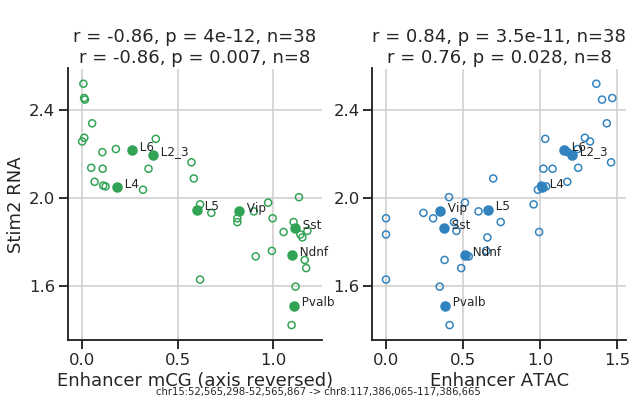

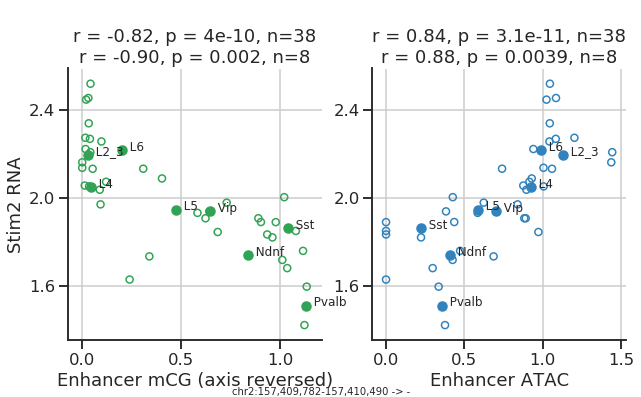

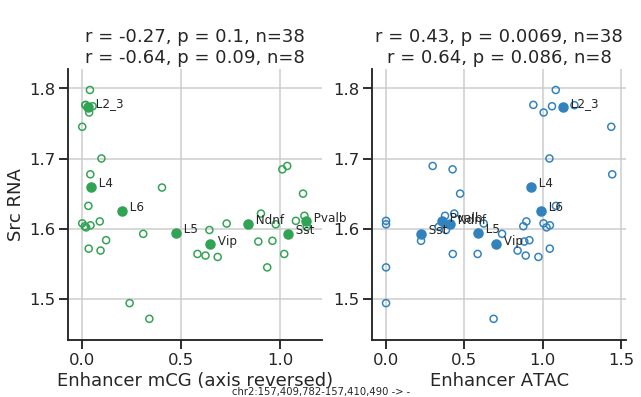

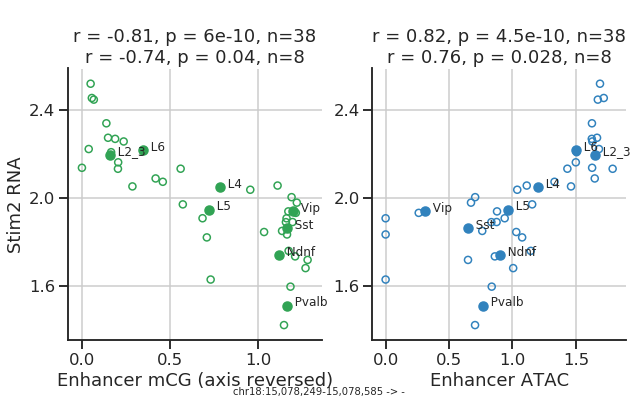

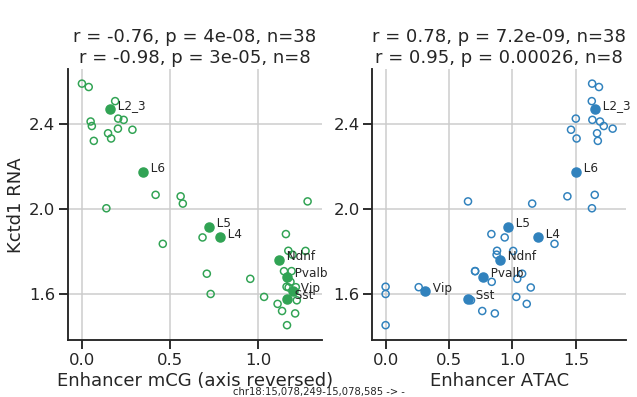

In [268]:
# correlate all enhancers with the gene (for both mC and ATAC)
resolution = 10000


# # (enh, gene_fp_name)
# candidates = [
# #     (corrs.iloc[[6]].index[0], 'Manbal'), 
#     (corrs.iloc[[6]].index[0], 'Src'), 
#     (corrs.iloc[[11]].index[0], 'Kctd1'), 
# ]

for enh, gene_fp_name in candidates:
    #### data
    gene_fp_id = df_genes.reset_index().set_index('gene_name').loc[gene_fp_name, 'gid']
    gene_fp_rna_y = gene_rna_clsts.loc[gene_fp_id, shared_clusters]
    enh_fp_mc_x = enh_mcg_clsts[shared_clusters]
    enh_fp_atac_x = enh_atac_clsts[shared_clusters]
    corrs_fp = get_corr(gene_fp_rna_y, enh_fp_mc_x.loc[[enh]], enh_fp_atac_x.loc[[enh]])

    # 38 clusters -> 8 clusters
    # correlate across 8 clusters now
    gene_fp_rna_y1 = summarize_by_broad_clsts(gene_fp_rna_y.to_frame().T, clst_annot_broad).iloc[0]
    enh_fp_mc_x1 = summarize_by_broad_clsts(enh_fp_mc_x, clst_annot_broad)
    enh_fp_atac_x1 = summarize_by_broad_clsts(enh_fp_atac_x, clst_annot_broad)
    corrs_fp_8clsts = get_corr(gene_fp_rna_y1, enh_fp_mc_x1.loc[[enh]], enh_fp_atac_x1.loc[[enh]])
    
    # r and p
    r1, p1 = stats.spearmanr(gene_rna_y, enh_mc_x.loc[enh])
    r2, p2 = stats.spearmanr(gene_rna_y, enh_atac_x.loc[enh])
    r_fp1, p_fp1 = stats.spearmanr(gene_fp_rna_y, enh_fp_mc_x.loc[enh])
    r_fp2, p_fp2 = stats.spearmanr(gene_fp_rna_y, enh_fp_atac_x.loc[enh])
    print(r1, p1)
    print(r2, p2)
    print(r_fp1, p_fp1)
    print(r_fp2, p_fp2)
    
    #### browser view
    chrom, start, end = enh_list_orig.set_index('index').loc[enh, ['chr', 'start', 'end']] 
    loc_tag = "{}:{}:300:1".format(chrom[len('chr'):], start)
    url = config_url(loc_tag=loc_tag, track_tag=track_tag)
    print(i, chrom, start, end)
    print(url)
    
    #### plots 
    # scatter plot
    output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
                  'scatter_38and8_clusters_stim2_enh{}_{}.pdf'
                  .format(enh, today)
                 )
    fig, axs = plt.subplots(1, 2, figsize=(5*2,5),sharey=False)
    # plot 38 clusters
    # this is to make sure the two plots (38 clusters and 8 clusters) have the same axis
    (ax0_xlim, ax0_xticks, ax1_xlim, ax1_xticks, ax_ylim, ax_yticks) = plot_scatter5(
        fig, axs,
        gene_name, enh, 
        enh_list_orig, enh_list, 
        gene_rna_y, enh_mc_x, enh_atac_x,
        s=50,
        facecolor='none',
        )
    
    # plot 8 clusters
    (ax0_xlim, ax0_xticks, ax1_xlim, ax1_xticks, ax_ylim, ax_yticks) = plot_scatter5(
        fig, axs,
        gene_name, enh, 
        enh_list_orig, enh_list, 
        gene_rna_y1, enh_mc_x1, enh_atac_x1,
        labelpoints=True,
        annotate=False,
        )
    print(output_fig)
    snmcseq_utils.savefig(fig, output_fig)
    

    ## fps
    output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
                  'scatter_38and8_clusters_stim2_fp_enh{}_{}.pdf'
                  .format(enh, today)
                 )
    fig, axs = plt.subplots(1, 2, figsize=(5*2,5),sharey=False)
    # plot 38 clusters
    (ax0_xlim, ax0_xticks, ax1_xlim, ax1_xticks, ax_ylim, ax_yticks) = plot_scatter5(
        fig, axs,
        gene_fp_name, enh, 
        enh_list_orig, enh_list, 
        gene_fp_rna_y, enh_fp_mc_x, enh_fp_atac_x,
        s=50,
        facecolor='none',
        )
    # plot 8 clusters
    (ax0_xlim, ax0_xticks, ax1_xlim, ax1_xticks, ax_ylim, ax_yticks) = plot_scatter5(
        fig, axs,
        gene_fp_name, enh, 
        enh_list_orig, enh_list, 
        gene_fp_rna_y1, enh_fp_mc_x1, enh_fp_atac_x1,
        labelpoints=True,
        annotate=False,
        )
    print(output_fig)
    snmcseq_utils.savefig(fig, output_fig)
    
#     break
    

### number of enhs correlated with Stim2 (for text)
- note that the total number of enhancers 152,104 are pre-selected by
- remove enhancers that has <20 mCG coverage in <1/2 of the 38 clusters 
- remove enhancers that has < 1 ATAC covrage in <1/2 of the 38 clusters
- take the union of the remaining ones 

See script `01.preproc_data_10xv3cells_38clusters-Oct01.ipynb`

In [42]:
# Stim2
chrom, start, end = 'chr5', 53942280, 53943483
center = 1/2*(start+end)
print(center)

53942881.5


In [75]:
ps1 = []
ps2 = []
rs1 = []
rs2 = []
for i in tqdm.tqdm(np.arange(len(enh_mc_x))):
#     if i % 10000 == 0:
#         print(i)
    r1, p1 = stats.spearmanr(gene_rna_y, enh_mc_x.iloc[i])
    r2, p2 = stats.spearmanr(gene_rna_y, enh_atac_x.iloc[i])
    ps1.append(p1)
    ps2.append(p2)
    
    rs1.append(r1)
    rs2.append(r2)
    

100%|██████████| 152104/152104 [02:31<00:00, 1002.24it/s]


In [76]:
# multiple comparison correction
# from statsmodels.stats.multitest import multipletests
_, qs1, _, _ = multipletests(ps1, method='fdr_bh')
_, qs2, _, _ = multipletests(ps2, method='fdr_bh')

In [77]:
print(("Num of enhancers significantly correlated with Stim2 expression:\n"
       "mCG-RNA {:,}\n"
       "ATAC-RNA {:,}\n" 
       "both {:,}\n" 
     ).format((qs1<0.05).sum(), (qs2<0.05).sum(), ((qs1<0.05) & (qs2<0.05)).sum())
     )


Num of enhancers significantly correlated with Stim2 expression:
mCG-RNA 84,588
ATAC-RNA 32,784
both 25,028



In [79]:
enh_annot = enh_list_orig.set_index('index').reindex(enh_mc_x.index).copy() #enh_mc_x.index
enh_annot['r1'] = rs1
enh_annot['r2'] = rs2

enh_annot_sig = enh_annot[((qs1<0.05) & (qs2<0.05))]

"all vs. different chromosomes {:,} vs. {:,}".format(
    len(enh_annot_sig), len(enh_annot_sig[enh_annot_sig['chr']!='chr5'])
    )

'all vs. different chromosomes 25,028 vs. 23,526'

In [80]:
gene_stim2 = genes_list_orig[genes_list_orig['gene_name']=='Stim2']
gene_stim2

,gid,gene_id,gene_name,chr,start,end,strand,gene_type,chrom,length,tss
7442,ENSMUSG00000039156,ENSMUSG00000039156.19,Stim2,chr5,53998499,54121057,+,protein_coding,5,122558,53998499


In [81]:
tmp_all = enh_annot.loc[enh_annot['chr']=='chr5', 'center'] - int(gene_stim2['tss'])
(np.abs(tmp_all) < 100*KB).sum()

33

In [82]:
tmp_sig = enh_annot_sig.loc[enh_annot_sig['chr']=='chr5', 'center'] - int(gene_stim2['tss'])
(np.abs(tmp_sig) < 100*KB).sum() #, (np.abs(tmp_sig) < 500*KB).sum(), (np.abs(tmp_sig) < 1000*KB).sum()

16

In [85]:
tmp_res = enh_annot.loc[tmp_sig[(np.abs(tmp_sig) < 100*KB)].index]
print(tmp_res.shape)
tmp_res

(16, 9)


,chr,start,end,clsts,length,chrom,center,r1,r2
index,,,,,,,,,
171575,chr5,53898385,53898717,NaN,332,5,53898551,-0.597330,0.554145
171576,chr5,53926006,53926641,NaN,635,5,53926323,-0.713098,0.673051
171577,chr5,53926729,53927246,NaN,517,5,53926987,-0.674581,0.641317
171578,chr5,53927305,53928317,NaN,1012,5,53927811,-0.754021,0.633038
171581,chr5,53940250,53940702,NaN,452,5,53940476,-0.399059,0.831180
171582,chr5,53941272,53941774,NaN,502,5,53941523,-0.696247,0.917547
171583,chr5,53941798,53942254,NaN,456,5,53942026,-0.790130,0.916015
171584,chr5,53942280,53943483,NaN,1203,5,53942881,-0.872634,0.870883
171588,chr5,53946111,53948495,NaN,2384,5,53947303,-0.745268,0.779796


In [87]:
tmp_res[['r1', 'r2']].describe()

,r1,r2
count,16.000000,16.000000
mean,-0.663430,0.642042
std,0.136096,0.177165
min,-0.872634,0.421531
25%,-0.762501,0.493217
50%,-0.702703,0.637178
75%,-0.570850,0.792642
max,-0.399059,0.917547


In [156]:
tmp_res[['r1', 'r2']].abs().mean(axis=1).drop(171584).describe()

count    15.000000
mean      0.638135
std       0.120715
min       0.458071
25%       0.543161
50%       0.622140
75%       0.714018
max       0.853072
dtype: float64

In [110]:
tmp_res_all = enh_annot.loc[tmp_all[(np.abs(tmp_all) < 100*KB)].index]
print(tmp_res_all.shape)
tmp_res_all.head()

(33, 9)


,chr,start,end,clsts,length,chrom,center,r1,r2
index,,,,,,,,,
171575,chr5,53898385,53898717,NaN,332,5,53898551,-0.597330,0.554145
171576,chr5,53926006,53926641,NaN,635,5,53926323,-0.713098,0.673051
171577,chr5,53926729,53927246,NaN,517,5,53926987,-0.674581,0.641317
171578,chr5,53927305,53928317,NaN,1012,5,53927811,-0.754021,0.633038
171579,chr5,53929036,53929555,NaN,519,5,53929295,-0.331218,0.556817


### HiC for those enhancers

In [115]:
resolution = 10000
# resolution = 5000
gene_name = 'Stim2'
gene_id = gene_stim2['gid'].iloc[0]
chromosome_spec = tss_list.set_index('gid').loc[gene_id, 'chr']
print(gene_name, gene_id, chromosome_spec) # liftedOver chromosome

todo = []
for enh_idx in tmp_res_all.index:
    todo.append({'gene': gene_id, 
                 'enh': enh_idx,
                })
todo = pd.DataFrame(todo)
print(todo.shape)

# get a list of candidate pairs
chromosome = chromosome_spec
# all enhancers and tss on that chromosomes
enhs = enh_list[enh_list['chr']==chromosome]
tsss = tss_list[tss_list['chr']==chromosome]
# get paired bins
paired_bin_table = enh_gene_id_to_binidx(todo, tsss, enhs, resolution)
print(paired_bin_table.shape)
paired_bin_table

Stim2 ENSMUSG00000039156 chr4
(33, 2)
(24, 11)


,enh,gene,gene_chr,gene_start,gene_end,enh_chr,enh_start,enh_end,enh_center,enh_bin,gene_bin
dist_bin,,,,,,,,,,,
8,171576,ENSMUSG00000039156,chr4,26860771,26860772,chr4,26782570,26783245,26782907.5,2678,2686
8,171577,ENSMUSG00000039156,chr4,26860771,26860772,chr4,26783332,26784946,26784139.0,2678,2686
8,171578,ENSMUSG00000039156,chr4,26860771,26860772,chr4,26785007,26785973,26785490.0,2678,2686
8,171579,ENSMUSG00000039156,chr4,26860771,26860772,chr4,26787034,26787906,26787470.0,2678,2686
7,171580,ENSMUSG00000039156,chr4,26860771,26860772,chr4,26792551,26792944,26792747.5,2679,2686
6,171582,ENSMUSG00000039156,chr4,26860771,26860772,chr4,26803078,26803600,26803339.0,2680,2686
6,171583,ENSMUSG00000039156,chr4,26860771,26860772,chr4,26803628,26804306,26803967.0,2680,2686
6,171584,ENSMUSG00000039156,chr4,26860771,26860772,chr4,26804388,26805669,26805028.5,2680,2686
6,171585,ENSMUSG00000039156,chr4,26860771,26860772,chr4,26805707,26806238,26805972.5,2680,2686


In [116]:
gene_bin = paired_bin_table['gene_bin'].iloc[0]
chromosome = chromosome_spec
enh_bins = np.sort(paired_bin_table['enh_bin'].values)
enh_names = ["{}:{:,},{:,}".format(_chr, _start, _end)
             for (_chr, _start, _end) in zip(paired_bin_table['enh_chr'], 
                                             paired_bin_table['enh_start'], 
                                             paired_bin_table['enh_end'])
            ]

# get relevant mats
mats_all = {}
for celltype in tqdm.tqdm(celltypes):
    resource_string = (
         '/cndd2/fangming/sphere_old/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
         '::/resolutions/{}'.format(celltype, resolution)
         )
    c = cooler.Cooler(resource_string)
    mat_all = c.matrix(balance=True).fetch(chromosome)
    
    name = "{} {}".format(celltype, chromosome)
    
    if name not in mats_all.keys(): 
        mats_all["{} {}".format(celltype, chromosome)] = mat_all
        
# get contacts on the specific location
contact_by_clsts = []
for i, (idx, row) in enumerate(paired_bin_table.iterrows()):
    gene_bin, enh_bin = row[['gene_bin', 'enh_bin']]
    
    for celltype in celltypes:
        mat_all = mats_all["{} {}".format(celltype, chromosome)]
        val = mat_all[gene_bin, enh_bin]
        contact_by_clsts.append({
                    'local_pair_idx': i,
                    'celltype': celltype,
                    'contact': val, 
                   })
        
contact_by_clsts = pd.DataFrame(contact_by_clsts)
contact_by_clsts = contact_by_clsts.pivot(index='local_pair_idx', columns='celltype')['contact']
print(contact_by_clsts.shape)
contact_by_clsts.head()

100%|██████████| 8/8 [00:23<00:00,  3.00s/it]

(24, 8)


celltype,L2_3,L4,L5,L6,Ndnf,Pvalb,Sst,Vip
local_pair_idx,,,,,,,,
0,0.005449,0.000000,0.015919,0.00000,0.009198,0.000000,0.002237,0.009093
1,0.005449,0.000000,0.015919,0.00000,0.009198,0.000000,0.002237,0.009093
2,0.005449,0.000000,0.015919,0.00000,0.009198,0.000000,0.002237,0.009093
3,0.005449,0.000000,0.015919,0.00000,0.009198,0.000000,0.002237,0.009093
4,0.007857,0.005152,0.009632,0.00885,0.020567,0.011304,0.007564,0.002756


In [135]:
# start from this
paired_bin_table_spec = paired_bin_table #.iloc[[2]]
# gene and enhs
chromosome = chromosome_spec
gene_bin = paired_bin_table_spec['gene_bin'].iloc[0]
enh_bins = np.sort(paired_bin_table_spec['enh_bin'].values)

gene_id = paired_bin_table_spec['gene'].iloc[0]
enh_ids = paired_bin_table_spec['enh'].values
enh_names_orig = ["_".join(enh_list_orig.set_index('index').loc[enh_id][['chr', 'start', 'end']].astype(str))
                        for enh_id in enh_ids]
enh_names_lifted = ["_".join(row[['enh_chr', 'enh_start', 'enh_end']].astype(str)) 
                        for idx, row in paired_bin_table_spec.iterrows()]

# all info 
ploty = gene_rna_clsts.loc[gene_id, shared_clusters]
plotx1 = enh_mcg_clsts.loc[enh_ids, shared_clusters]
plotx2 = enh_atac_clsts.loc[enh_ids, shared_clusters]

# 38 clusters -> 8 clusters
plotyb1 = summarize_by_broad_clsts(ploty.to_frame().T, clst_annot_broad)
plotxb1 = summarize_by_broad_clsts(plotx1, clst_annot_broad)
plotxb2 = summarize_by_broad_clsts(plotx2, clst_annot_broad)
plotxb3 = contact_by_clsts

plotxb3.index=plotxb1.index 

print(plotyb1.shape, plotxb1.shape, plotxb2.shape, plotxb3.shape)

(1, 8) (24, 8) (24, 8) (24, 8)


In [181]:
rs = []
for i in np.arange(len(plotxb3)):
    _x, _y = plotxb3.iloc[i].values, plotyb1.iloc[0].values
    r, p = stats.spearmanr(_x, _y)
    rs.append(r)
rs = pd.Series(rs, index=plotxb3.index)
mean_contacts = plotxb3.mean(axis=1)

# rs1_8clsts = []
# for i in np.arange(len(plotxb1)):
#     _x, _y = plotxb1.iloc[i].values, plotyb1.iloc[0].values
#     r, p = stats.spearmanr(_x, _y)
#     rs1_8clsts.append(r)
# rs1_8clsts = pd.Series(rs1_8clsts, index=plotxb1.index)

# rs2_8clsts = []
# for i in np.arange(len(plotxb2)):
#     _x, _y = plotxb2.iloc[i].values, plotyb1.iloc[0].values
#     r, p = stats.spearmanr(_x, _y)
#     rs2_8clsts.append(r)
# rs2_8clsts = pd.Series(rs2_8clsts, index=plotxb2.index)

theone = 171584
(rs < rs.loc[theone]).sum(), (mean_contacts < mean_contacts[theone]).sum()

(20, 15)

/cndd2/fangming/projects/scf_enhancers/figures/fig1j_scatter_contact_mCG_ATAC.pdf


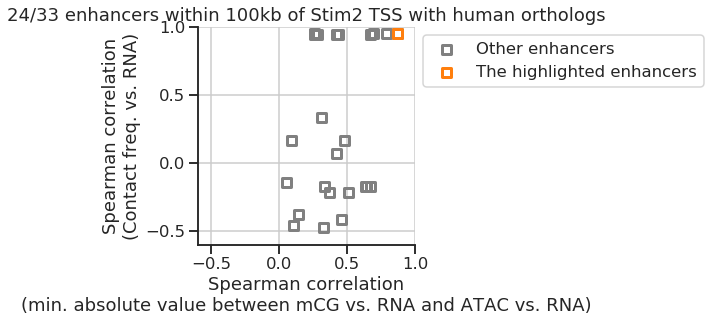

In [229]:
tmp_res_all['r1'].shape

# sns.boxplot(tmp_res_all['r1'], )
# sns.stripplot(tmp_res_all['r1'], )

fig, ax = plt.subplots()
ax.scatter(
        tmp_res_all[['r1', 'r2']].abs().min(axis=1).reindex(rs.index), 
        rs,
        marker='s',
#         color='gray',
        facecolor='none',
        edgecolor='gray',
        linewidth=3,
        label='Other enhancers'
        )
ax.scatter(
        tmp_res_all[['r1', 'r2']].abs().min(axis=1).reindex([theone]), 
        rs.reindex([theone]),
        marker='s',
#         color='C1',
        facecolor='none',
        edgecolor='C1',
        linewidth=3,
        label='The highlighted enhancers'
        )

ax.set_xlim([-0.6,1])
ax.set_ylim([-0.6,1])
ax.set_aspect('equal')
ax.set_xlabel('Spearman correlation\n(min. absolute value between mCG vs. RNA and ATAC vs. RNA)')
ax.set_ylabel('Spearman correlation\n(Contact freq. vs. RNA)')
sns.despine(ax=ax)

ax.set_title('{}/{} enhancers within 100kb of Stim2 TSS with human orthologs'.format(len(rs), len(tmp_res_all)))
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

output_fig = ('/cndd2/fangming/projects/scf_enhancers/figures/'
              'fig1j_scatter_contact_mCG_ATAC.pdf'
              .format(enh, today)
             )
print(output_fig)
snmcseq_utils.savefig(fig, output_fig)
plt.show()

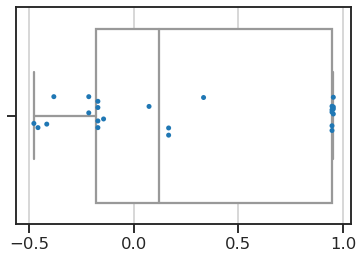

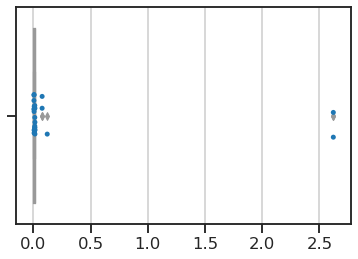

In [150]:
sns.boxplot(rs.to_frame(), color='white')
sns.stripplot(rs.to_frame())
plt.show()

sns.boxplot(mean_contacts.to_frame(), color='white')
sns.stripplot(mean_contacts.to_frame())
plt.show()

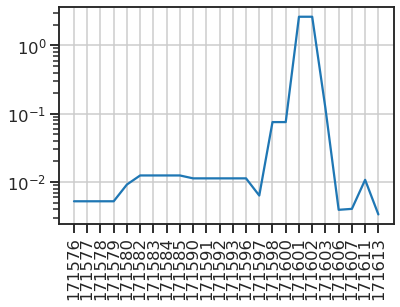

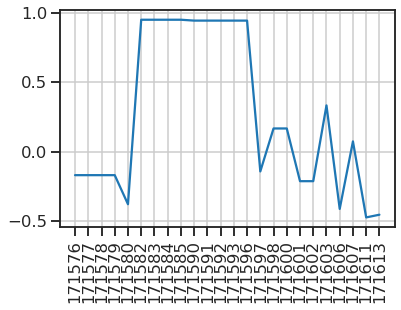

In [138]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(plotxb3.index.values)), plotxb3.mean(axis=1).values)
ax.set_xticks(np.arange(len(plotxb3)))
ax.set_xticklabels(plotxb3.index.values, rotation=90)
ax.set_yscale('log')
plt.show()

fig, ax = plt.subplots()
ax.plot(np.arange(len(rs)), rs)
ax.set_xticks(np.arange(len(rs)))
ax.set_xticklabels(plotxb3.index.values, rotation=90)
# ax.set_yscale('log')
plt.show()

/cndd2/fangming/projects/scf_enhancers/figures/scatter_38clusters_Stim2_2021-04-21.pdf


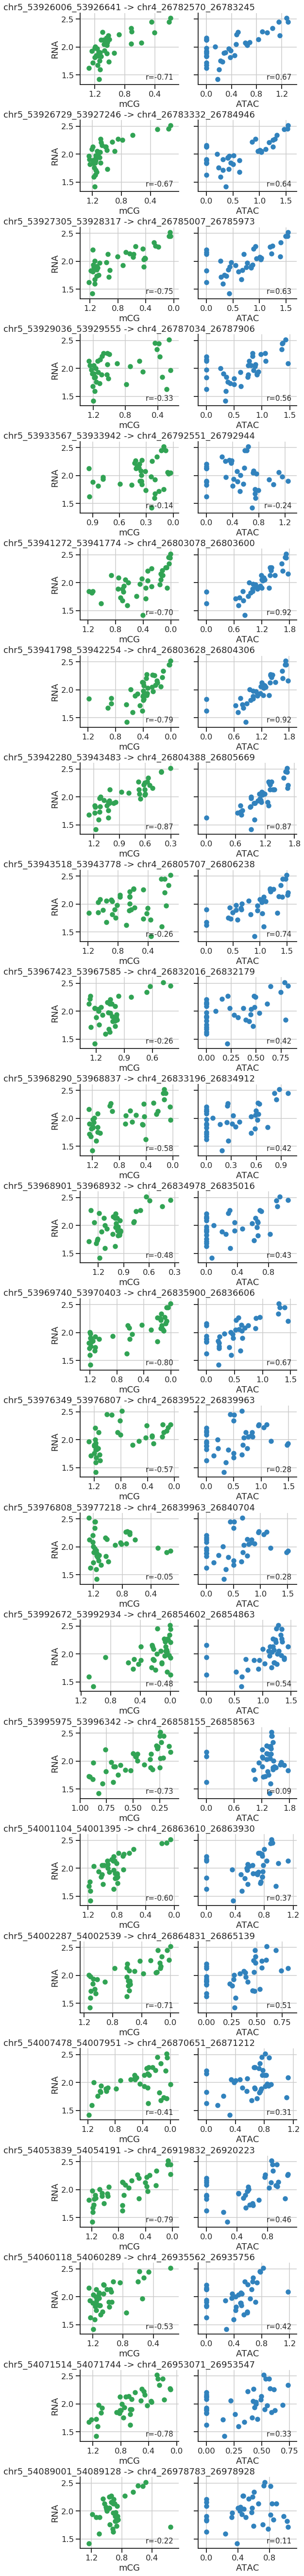

/cndd2/fangming/projects/scf_enhancers/figures/scatter_8clusters_Stim2_2021-04-21.pdf


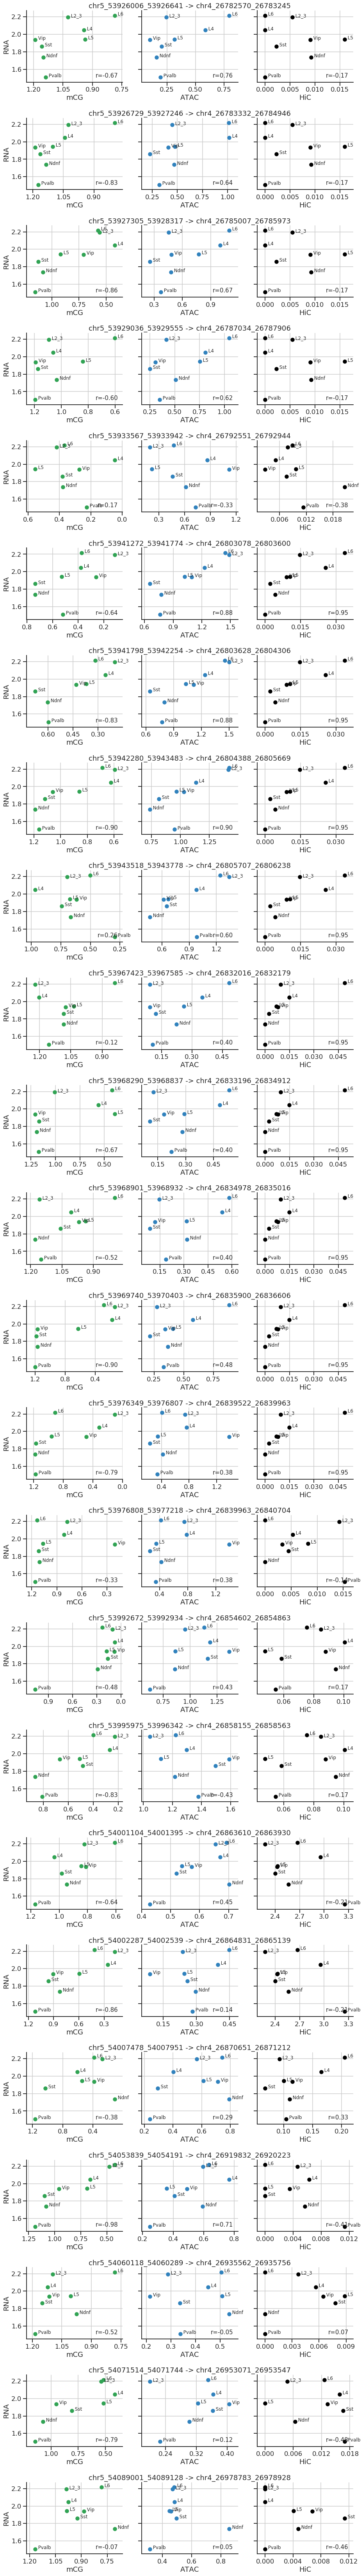

In [114]:
# plot
plot_scatter1(gene_name, enh_names_orig, enh_names_lifted, 
              ploty, plotx1, plotx2,
              subplot_colors_mc_atac)
plot_scatter2(gene_name, enh_names_orig, enh_names_lifted, 
              plotyb1, plotxb1, plotxb2, plotxb3, 
              subplot_colors_mc_atac_hic)

